In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import optuna 
import functools
from scipy import stats
import datetime

def opt(X_train, y_train, X_test, y_test, trial): 
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
#     tree_method = trial.suggest_categorical('tree_method', ['exact','approx','hist'])
    objective = trial.suggest_categorical('objective', ['reg:linear'])
    eval_metric = trial.suggest_categorical('eval_metric', ['rmse'])
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.1, 0.11, 0.01)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    xgboost_tuna = xgb.XGBRegressor(
        random_state=0, 
        n_estimators = n_estimators,
#         tree_method = tree_method,
        objective = objective,
        eval_metric =eval_metric,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_test)
#     return (median_absolute_error(y_test, tuna_pred_test))
    return (np.sqrt(MSE(y_test, tuna_pred_test)))


def weekendflag(df,weekdays):
    df9=df.copy()
    df9['ml']=df9['date'].apply(lambda x: x.weekday())
    df9['weekend']=df9['ml'].apply(lambda x: 1 if(x in weekdays) else 0)
    df9.drop(['ml'], axis=1,inplace=True)
    return df9


def XGBForecaster(df,frequency = 'hourly'):
    if frequency == 'hourly':
        df['date'] = pd.to_datetime(df['date'],format='%d-%m-%Y %H:%M')
        df5 = df.copy()
#         df5=zscore(df5)
        df5 = create_features_hourly(df)
        df5=weekendflag(df5,[5,6])
        df5.sort_values('date',inplace=True)
#         print(df5.info())
#         print(df5)
        df5["value"] = df5["value"].fillna(value=df5["value"].mean())
        df5 = df.set_index('date')
        #     print(df5.info())
        #     print(df5.head())

        X = df5.loc[:,['temperature','var1','pressure','windspeed','var2','hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','weekend']]
        y=df5.loc[:,'value']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)
        study = optuna.create_study()
        study.optimize(functools.partial(opt, X_train, y_train, X_test, y_test), n_trials=100)
        xg_reg5 = xgb.XGBRegressor(**study.best_params)
        m5 =xg_reg5.fit(X,y)
        
        data_pred = pd.read_csv(r'test_pavJagI.csv')
        data_pred5 =data_pred.copy()
        data_pred5 =data_pred5.iloc[:,1:]
        data_pred5['var2'] = data_pred5['var2'].map({'A': 0, 'B': 1,'C': 2})
        data_pred5.rename(columns = {'datetime':'date'}, inplace = True)
        data_pred5['date'] = pd.to_datetime(data_pred5['date'],format='%Y-%m-%d %H:%M')
        data_pred5 = create_features_hourly1(data_pred5)
        data_pred5=weekendflag(data_pred5,[5,6])
        data = pd.DataFrame()
        for year in data_pred5['date'].dt.year.unique():
            data_pred6 = data_pred5[data_pred5['date'].dt.year == year]
            data_pred6['date'] = pd.to_datetime(data_pred6['date'],format='%Y-%m-%d %H:%M')
            for month in data_pred6['date'].dt.month.unique():
                data_pred7 = data_pred6[data_pred6['date'].dt.month == month]
                data_pred7['date'] = pd.to_datetime(data_pred7['date'],format='%Y-%m-%d %H:%M')
                data_pred7.index=data_pred7['date']
                data_pred7.drop('date',axis=1,inplace = True)
                y_pred7 = pd.DataFrame(m5.predict(data_pred7),columns=['value']).values.flatten()
    #     print(y_pred5)
                data_pred7['value'] = y_pred7
                data_pred7['date'] = data_pred7.index
                outputDf=data_pred7[['date','value']]
                print(outputDf.head(1))
                data = data.append(outputDf)
#                 print(data.head(2))
#                 print(data.info())
        data.to_csv('pred_all3.csv')   
    return data
  

def create_features_hourly(df):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['temperature','var1','pressure','windspeed','var2',
            'date',
            'hour',
            'dayofweek',
            'quarter',
            'month',
            'year',
            'dayofyear',
            'dayofmonth',
            'weekofyear','value']]
    return X

def create_features_hourly1(df):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X2 = df[['temperature','var1','pressure','windspeed','var2',
             'date',
             'hour',
             'dayofweek',
             'quarter',
             'month',
             'year',
             'dayofyear',
             'dayofmonth',
             'weekofyear']]
    return X2


import os
cwd = os.getcwd()
print(cwd,flush=True)
import sys


C:\Users\sourav.modi\Documents


In [6]:
class test(object):
    def runMlAlgorithms(self,inputData2,upperLimit,lowerLimit,frequency='hourly'):
        outputDf = XGBForecaster(inputData2,frequency = 'hourly')
        outputDf['value'] = np.where(outputDf['value']<lowerLimit,lowerLimit,outputDf['value'])
        outputDf['value'] = np.where(outputDf['value']>upperLimit,upperLimit,outputDf['value'])


In [7]:
if __name__ == "__main__":
    t = test()
    inputData = pd.read_csv(r'train_6BJx641.csv')
    inputData = inputData.iloc[:,1:]
    inputData['var2'] = inputData['var2'].map({'A': 0, 'B': 1,'C': 2})
#     print(inputData['var2'].dtypes)
#     print(inputData['var2'].values)
    inputData.rename(columns = {'datetime':'date', 'electricity_consumption':'value'}, inplace = True)
    inputData['date'] = pd.to_datetime(inputData['date'],format='%Y-%m-%d %H:%M')
    for year in inputData['date'].dt.year.unique():
        inputData1 = inputData[inputData['date'].dt.year == year]
        inputData1['date'] = pd.to_datetime(inputData1['date'],format='%Y-%m-%d %H:%M')
        for month in inputData1['date'].dt.month.unique():
            inputData2 = inputData1[inputData1['date'].dt.month == month]
            inputData2['date'] = pd.to_datetime(inputData2['date'],format='%Y-%m-%d %H:%M')
            t.runMlAlgorithms(inputData2,10000000000000000,0,frequency='hourly')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[I 2020-05-03 22:06:39,329] Finished trial#12 with value: 33.50227463472448 with parameters: {'n_estimators': 210, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#11 with value: 33.487886645353164.
[I 2020-05-03 22:06:39,570] Finished trial#13 with value: 34.305026610410685 with parameters: {'n_estimators': 187, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#11 with value: 33.487886645353164.
[I 2020-05-03 22:06:39,908] Finished trial#14 with value: 33.498675782188364 with parameters: {'n_estimators': 211, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#11 with value: 33.487886645353164.
[I 2020-05-03 22:06:40,321] Finished t

[I 2020-05-03 22:06:48,836] Finished trial#37 with value: 34.41233823321421 with parameters: {'n_estimators': 290, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#27 with value: 32.07183245391546.
[I 2020-05-03 22:06:49,114] Finished trial#38 with value: 32.08659002176745 with parameters: {'n_estimators': 228, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#27 with value: 32.07183245391546.
[I 2020-05-03 22:06:49,290] Finished trial#39 with value: 37.74509633428666 with parameters: {'n_estimators': 330, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#27 with value: 32.07183245391546.
[I 2020-05-03 22:06:49,507] Finished trial#4

[I 2020-05-03 22:06:55,871] Finished trial#62 with value: 32.70996935986063 with parameters: {'n_estimators': 200, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#42 with value: 32.05769735069454.
[I 2020-05-03 22:06:56,162] Finished trial#63 with value: 32.08048328284128 with parameters: {'n_estimators': 177, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#42 with value: 32.05769735069454.
[I 2020-05-03 22:06:56,607] Finished trial#64 with value: 32.72229481186533 with parameters: {'n_estimators': 272, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#42 with value: 32.05769735069454.
[I 2020-05-03 22:06:56,899] Finished trial#

[I 2020-05-03 22:07:03,904] Finished trial#87 with value: 32.83830388829631 with parameters: {'n_estimators': 216, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#42 with value: 32.05769735069454.
[I 2020-05-03 22:07:04,296] Finished trial#88 with value: 34.215457248822666 with parameters: {'n_estimators': 250, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#42 with value: 32.05769735069454.
[I 2020-05-03 22:07:04,592] Finished trial#89 with value: 33.158362210598874 with parameters: {'n_estimators': 195, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#42 with value: 32.05769735069454.
[I 2020-05-03 22:07:04,864] Finished tria

                 date      value
date                            
2013-07-24 2013-07-24  208.48587
                 date       value
date                             
2013-08-24 2013-08-24  264.488831
                 date       value
date                             
2013-09-24 2013-09-24  244.512451
                 date       value
date                             
2013-10-24 2013-10-24  245.959122
                 date       value
date                             
2013-11-24 2013-11-24  285.748962
                 date       value
date                             
2013-12-24 2013-12-24  292.105713
                 date       value
date                             
2014-01-24 2014-01-24  312.003235
                 date       value
date                             
2014-02-24 2014-02-24  301.737061
                 date       value
date                             
2014-03-24 2014-03-24  292.387482
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:07:13,583] Finished trial#13 with value: 58.62417104670231 with parameters: {'n_estimators': 129, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 57.53565023086761.
[I 2020-05-03 22:07:14,007] Finished trial#14 with value: 58.39591538923362 with parameters: {'n_estimators': 230, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#11 with value: 57.53565023086761.
[I 2020-05-03 22:07:14,310] Finished trial#15 with value: 61.11018988653504 with parameters: {'n_estimators': 151, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#11 with value: 57.53565023086761.
[I 2020-05-03 22:07:14,481] Finished trial#1

[I 2020-05-03 22:07:27,447] Finished trial#38 with value: 58.47220639623226 with parameters: {'n_estimators': 323, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#24 with value: 56.724131666050845.
[I 2020-05-03 22:07:28,308] Finished trial#39 with value: 61.03177747457183 with parameters: {'n_estimators': 386, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#24 with value: 56.724131666050845.
[I 2020-05-03 22:07:28,931] Finished trial#40 with value: 60.71038262495913 with parameters: {'n_estimators': 302, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#24 with value: 56.724131666050845.
[I 2020-05-03 22:07:29,744] Finished tr

[I 2020-05-03 22:07:45,264] Finished trial#63 with value: 56.813771306693184 with parameters: {'n_estimators': 269, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#53 with value: 56.366121443903054.
[I 2020-05-03 22:07:45,746] Finished trial#64 with value: 56.82655560256214 with parameters: {'n_estimators': 244, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#53 with value: 56.366121443903054.
[I 2020-05-03 22:07:46,176] Finished trial#65 with value: 59.97998788644788 with parameters: {'n_estimators': 260, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#53 with value: 56.366121443903054.
[I 2020-05-03 22:07:46,618] Finished tr

[I 2020-05-03 22:07:56,172] Finished trial#88 with value: 59.567754990056564 with parameters: {'n_estimators': 251, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#53 with value: 56.366121443903054.
[I 2020-05-03 22:07:56,519] Finished trial#89 with value: 59.26468076376532 with parameters: {'n_estimators': 310, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#53 with value: 56.366121443903054.
[I 2020-05-03 22:07:56,931] Finished trial#90 with value: 56.691046016653814 with parameters: {'n_estimators': 259, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#53 with value: 56.366121443903054.
[I 2020-05-03 22:07:57,288] Finished t

                 date       value
date                             
2013-07-24 2013-07-24  545.627869
                 date       value
date                             
2013-08-24 2013-08-24  644.223694
                 date       value
date                             
2013-09-24 2013-09-24  675.606628
                 date       value
date                             
2013-10-24 2013-10-24  637.983398
                 date       value
date                             
2013-11-24 2013-11-24  684.683533
                 date       value
date                             
2013-12-24 2013-12-24  674.553894
                 date       value
date                             
2014-01-24 2014-01-24  552.451721
                 date       value
date                             
2014-02-24 2014-02-24  524.969238
                 date       value
date                             
2014-03-24 2014-03-24  552.503174
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:08:11,531] Finished trial#13 with value: 37.193814579939335 with parameters: {'n_estimators': 101, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#4 with value: 33.342893675617326.
[I 2020-05-03 22:08:11,936] Finished trial#14 with value: 35.79287816600202 with parameters: {'n_estimators': 203, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#4 with value: 33.342893675617326.
[I 2020-05-03 22:08:12,729] Finished trial#15 with value: 35.24926809215913 with parameters: {'n_estimators': 291, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#4 with value: 33.342893675617326.
[I 2020-05-03 22:08:12,937] Finished trial#

[I 2020-05-03 22:08:21,253] Finished trial#38 with value: 32.82884960356676 with parameters: {'n_estimators': 303, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#29 with value: 32.73086152378365.
[I 2020-05-03 22:08:21,666] Finished trial#39 with value: 32.775490318766806 with parameters: {'n_estimators': 254, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#29 with value: 32.73086152378365.
[I 2020-05-03 22:08:22,086] Finished trial#40 with value: 37.59528657398148 with parameters: {'n_estimators': 276, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial#29 with value: 32.73086152378365.
[I 2020-05-03 22:08:22,480] Finished tri

[I 2020-05-03 22:08:32,708] Finished trial#63 with value: 33.84455086032071 with parameters: {'n_estimators': 199, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#57 with value: 32.25917047608896.
[I 2020-05-03 22:08:33,105] Finished trial#64 with value: 33.936509455579596 with parameters: {'n_estimators': 182, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#57 with value: 32.25917047608896.
[I 2020-05-03 22:08:33,622] Finished trial#65 with value: 33.544836540603086 with parameters: {'n_estimators': 240, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#57 with value: 32.25917047608896.
[I 2020-05-03 22:08:33,955] Finished tria

[I 2020-05-03 22:08:41,056] Finished trial#88 with value: 32.45204242862979 with parameters: {'n_estimators': 189, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#69 with value: 31.391787201533035.
[I 2020-05-03 22:08:41,348] Finished trial#89 with value: 33.812032555415364 with parameters: {'n_estimators': 251, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#69 with value: 31.391787201533035.
[I 2020-05-03 22:08:41,661] Finished trial#90 with value: 35.5279331596411 with parameters: {'n_estimators': 215, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#69 with value: 31.391787201533035.
[I 2020-05-03 22:08:41,934] Finished tri

                 date       value
date                             
2013-07-24 2013-07-24  186.185944
                 date       value
date                             
2013-08-24 2013-08-24  274.533081
                 date       value
date                             
2013-09-24 2013-09-24  209.171463
                 date      value
date                            
2013-10-24 2013-10-24  268.56958
                 date       value
date                             
2013-11-24 2013-11-24  276.210571
                 date       value
date                             
2013-12-24 2013-12-24  295.235138
                 date       value
date                             
2014-01-24 2014-01-24  312.921021
                 date       value
date                             
2014-02-24 2014-02-24  321.769012
                 date       value
date                             
2014-03-24 2014-03-24  326.940857
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:08:49,691] Finished trial#13 with value: 37.45981324185976 with parameters: {'n_estimators': 188, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#5 with value: 36.613091872490216.
[I 2020-05-03 22:08:49,910] Finished trial#14 with value: 37.464774673890076 with parameters: {'n_estimators': 151, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#5 with value: 36.613091872490216.
[I 2020-05-03 22:08:50,219] Finished trial#15 with value: 36.16339792312961 with parameters: {'n_estimators': 234, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#15 with value: 36.16339792312961.
[I 2020-05-03 22:08:50,440] Finished trial

[I 2020-05-03 22:08:55,814] Finished trial#38 with value: 36.84182000297026 with parameters: {'n_estimators': 210, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:08:56,050] Finished trial#39 with value: 36.63383694839673 with parameters: {'n_estimators': 154, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:08:56,202] Finished trial#40 with value: 37.69712884957701 with parameters: {'n_estimators': 136, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:08:56,428] Finished tri

[I 2020-05-03 22:09:02,250] Finished trial#63 with value: 36.0757627380695 with parameters: {'n_estimators': 148, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:09:02,461] Finished trial#64 with value: 35.34374340145438 with parameters: {'n_estimators': 109, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:09:02,646] Finished trial#65 with value: 36.33720451158851 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:09:02,848] Finished tria

[I 2020-05-03 22:09:07,837] Finished trial#88 with value: 36.060809310802924 with parameters: {'n_estimators': 134, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:09:08,231] Finished trial#89 with value: 35.80106034219639 with parameters: {'n_estimators': 347, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:09:08,408] Finished trial#90 with value: 36.37801669262904 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#22 with value: 34.960003060306356.
[I 2020-05-03 22:09:08,616] Finished tr

                 date      value
date                            
2013-07-24 2013-07-24  293.97699
                 date     value
date                           
2013-08-24 2013-08-24  351.1185
                 date       value
date                             
2013-09-24 2013-09-24  266.889221
                 date       value
date                             
2013-10-24 2013-10-24  269.068726
                 date       value
date                             
2013-11-24 2013-11-24  270.848083
                 date       value
date                             
2013-12-24 2013-12-24  313.183929
                 date       value
date                             
2014-01-24 2014-01-24  352.183319
                 date       value
date                             
2014-02-24 2014-02-24  304.498596
                 date       value
date                             
2014-03-24 2014-03-24  345.178497
                 date       value
date                             
2014-04-24 2014-04-24  

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:09:15,651] Finished trial#13 with value: 29.783079932168036 with parameters: {'n_estimators': 260, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#12 with value: 28.78072716951057.
[I 2020-05-03 22:09:15,877] Finished trial#14 with value: 32.36795527150554 with parameters: {'n_estimators': 118, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#12 with value: 28.78072716951057.
[I 2020-05-03 22:09:17,153] Finished trial#15 with value: 30.902046071858024 with parameters: {'n_estimators': 292, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#12 with value: 28.78072716951057.
[I 2020-05-03 22:09:17,722] Finished tri

[I 2020-05-03 22:09:27,610] Finished trial#38 with value: 28.97526332260769 with parameters: {'n_estimators': 329, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#31 with value: 28.291127646319733.
[I 2020-05-03 22:09:28,092] Finished trial#39 with value: 30.483969105857796 with parameters: {'n_estimators': 302, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#31 with value: 28.291127646319733.
[I 2020-05-03 22:09:28,512] Finished trial#40 with value: 29.72731008634739 with parameters: {'n_estimators': 276, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#31 with value: 28.291127646319733.
[I 2020-05-03 22:09:28,756] Finished t

[I 2020-05-03 22:09:36,537] Finished trial#63 with value: 28.688232049906308 with parameters: {'n_estimators': 249, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#31 with value: 28.291127646319733.
[I 2020-05-03 22:09:36,890] Finished trial#64 with value: 28.66940700811141 with parameters: {'n_estimators': 287, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#31 with value: 28.291127646319733.
[I 2020-05-03 22:09:37,261] Finished trial#65 with value: 28.66894562348752 with parameters: {'n_estimators': 292, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#31 with value: 28.291127646319733.
[I 2020-05-03 22:09:37,681] Finished tr

[I 2020-05-03 22:09:48,061] Finished trial#88 with value: 28.291228240327552 with parameters: {'n_estimators': 268, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#69 with value: 28.29069299258899.
[I 2020-05-03 22:09:48,494] Finished trial#89 with value: 30.318804789787542 with parameters: {'n_estimators': 269, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#69 with value: 28.29069299258899.
[I 2020-05-03 22:09:48,909] Finished trial#90 with value: 28.974853650287773 with parameters: {'n_estimators': 277, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#69 with value: 28.29069299258899.
[I 2020-05-03 22:09:49,394] Finished tr

                 date      value
date                            
2013-07-24 2013-07-24  259.12851
                 date       value
date                             
2013-08-24 2013-08-24  278.529846
                 date       value
date                             
2013-09-24 2013-09-24  264.451477
                 date       value
date                             
2013-10-24 2013-10-24  274.799683
                 date       value
date                             
2013-11-24 2013-11-24  301.598969
                 date      value
date                            
2013-12-24 2013-12-24  290.06958
                 date       value
date                             
2014-01-24 2014-01-24  341.781342
                 date       value
date                             
2014-02-24 2014-02-24  253.680511
                 date       value
date                             
2014-03-24 2014-03-24  253.716248
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:10:00,441] Finished trial#13 with value: 47.70888338245587 with parameters: {'n_estimators': 390, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#6 with value: 45.51910824123685.
[I 2020-05-03 22:10:00,998] Finished trial#14 with value: 50.05271616269179 with parameters: {'n_estimators': 396, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#6 with value: 45.51910824123685.
[I 2020-05-03 22:10:01,260] Finished trial#15 with value: 47.61610157850197 with parameters: {'n_estimators': 130, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#6 with value: 45.51910824123685.
[I 2020-05-03 22:10:01,733] Finished trial#16

[I 2020-05-03 22:10:15,534] Finished trial#38 with value: 50.75253116607657 with parameters: {'n_estimators': 290, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#6 with value: 45.51910824123685.
[I 2020-05-03 22:10:16,213] Finished trial#39 with value: 49.1653757689121 with parameters: {'n_estimators': 324, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial#6 with value: 45.51910824123685.
[I 2020-05-03 22:10:16,610] Finished trial#40 with value: 46.783571361961 with parameters: {'n_estimators': 174, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#6 with value: 45.51910824123685.
[I 2020-05-03 22:10:17,161] Finished trial#41 wit

[I 2020-05-03 22:10:28,214] Finished trial#63 with value: 45.60230897407597 with parameters: {'n_estimators': 354, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#58 with value: 45.48625951819375.
[I 2020-05-03 22:10:28,808] Finished trial#64 with value: 45.60231097335286 with parameters: {'n_estimators': 376, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#58 with value: 45.48625951819375.
[I 2020-05-03 22:10:29,351] Finished trial#65 with value: 45.602311223893075 with parameters: {'n_estimators': 370, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#58 with value: 45.48625951819375.
[I 2020-05-03 22:10:29,897] Finished tr

[I 2020-05-03 22:10:44,630] Finished trial#88 with value: 46.35519384397045 with parameters: {'n_estimators': 362, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#58 with value: 45.48625951819375.
[I 2020-05-03 22:10:45,574] Finished trial#89 with value: 49.650093174150065 with parameters: {'n_estimators': 374, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#58 with value: 45.48625951819375.
[I 2020-05-03 22:10:46,338] Finished trial#90 with value: 45.43341932632161 with parameters: {'n_estimators': 391, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#90 with value: 45.43341932632161.
[I 2020-05-03 22:10:47,027] Finished tria

                 date       value
date                             
2013-07-24 2013-07-24  211.972198
                 date       value
date                             
2013-08-24 2013-08-24  217.397568
                 date       value
date                             
2013-09-24 2013-09-24  216.053436
                 date       value
date                             
2013-10-24 2013-10-24  214.722366
                 date       value
date                             
2013-11-24 2013-11-24  265.278961
                 date       value
date                             
2013-12-24 2013-12-24  229.327591
                 date       value
date                             
2014-01-24 2014-01-24  247.467209
                 date       value
date                             
2014-02-24 2014-02-24  262.470032
                 date      value
date                            
2014-03-24 2014-03-24  235.76326
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[I 2020-05-03 22:11:02,005] Finished trial#12 with value: 32.010648596518195 with parameters: {'n_estimators': 179, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#12 with value: 32.010648596518195.
[I 2020-05-03 22:11:02,278] Finished trial#13 with value: 32.01743572992853 with parameters: {'n_estimators': 163, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#12 with value: 32.010648596518195.
[I 2020-05-03 22:11:02,548] Finished trial#14 with value: 31.46894209203894 with parameters: {'n_estimators': 153, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#14 with value: 31.46894209203894.
[I 2020-05-03 22:11:02,781] Finished trial

[I 2020-05-03 22:11:08,738] Finished trial#37 with value: 33.19446581909319 with parameters: {'n_estimators': 165, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#15 with value: 30.928363769494343.
[I 2020-05-03 22:11:09,090] Finished trial#38 with value: 31.603896881637613 with parameters: {'n_estimators': 201, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#15 with value: 30.928363769494343.
[I 2020-05-03 22:11:09,630] Finished trial#39 with value: 30.872488803172857 with parameters: {'n_estimators': 397, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:10,146] Finished tri

[I 2020-05-03 22:11:15,911] Finished trial#62 with value: 30.946611530883864 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:16,164] Finished trial#63 with value: 31.036548027259542 with parameters: {'n_estimators': 123, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:16,395] Finished trial#64 with value: 31.554932654070527 with parameters: {'n_estimators': 111, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:16,664] Finished t

[I 2020-05-03 22:11:23,242] Finished trial#87 with value: 33.40837759522887 with parameters: {'n_estimators': 118, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:23,433] Finished trial#88 with value: 34.69514571357177 with parameters: {'n_estimators': 130, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:23,911] Finished trial#89 with value: 31.507773205260328 with parameters: {'n_estimators': 300, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#39 with value: 30.872488803172857.
[I 2020-05-03 22:11:24,176] Finished tria

                 date       value
date                             
2013-07-24 2013-07-24  235.929199
                 date       value
date                             
2013-08-24 2013-08-24  227.871521
                 date       value
date                             
2013-09-24 2013-09-24  254.805771
                 date       value
date                             
2013-10-24 2013-10-24  251.997681
                 date       value
date                             
2013-11-24 2013-11-24  223.558899
                 date       value
date                             
2013-12-24 2013-12-24  276.666992
                 date       value
date                             
2014-01-24 2014-01-24  270.525116
                 date       value
date                             
2014-02-24 2014-02-24  286.615143
                 date       value
date                             
2014-03-24 2014-03-24  251.746979
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:11:33,249] Finished trial#13 with value: 25.32383430212399 with parameters: {'n_estimators': 316, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#13 with value: 25.32383430212399.
[I 2020-05-03 22:11:33,523] Finished trial#14 with value: 26.04874184066554 with parameters: {'n_estimators': 338, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#13 with value: 25.32383430212399.
[I 2020-05-03 22:11:33,854] Finished trial#15 with value: 26.127711620115345 with parameters: {'n_estimators': 319, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#13 with value: 25.32383430212399.
[I 2020-05-03 22:11:34,246] Finished trial#16

[I 2020-05-03 22:11:49,069] Finished trial#38 with value: 27.4399722863978 with parameters: {'n_estimators': 194, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#23 with value: 25.00692559653488.
[I 2020-05-03 22:11:49,701] Finished trial#39 with value: 25.166929459076407 with parameters: {'n_estimators': 220, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#23 with value: 25.00692559653488.
[I 2020-05-03 22:11:50,344] Finished trial#40 with value: 28.135055900767206 with parameters: {'n_estimators': 195, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial#23 with value: 25.00692559653488.
[I 2020-05-03 22:11:50,991] Finished trial#

[I 2020-05-03 22:12:03,090] Finished trial#63 with value: 25.052925507982344 with parameters: {'n_estimators': 163, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#23 with value: 25.00692559653488.
[I 2020-05-03 22:12:03,723] Finished trial#64 with value: 25.16443801925843 with parameters: {'n_estimators': 207, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#23 with value: 25.00692559653488.
[I 2020-05-03 22:12:04,291] Finished trial#65 with value: 25.580565202260317 with parameters: {'n_estimators': 187, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#23 with value: 25.00692559653488.
[I 2020-05-03 22:12:04,725] Finished trial#

[I 2020-05-03 22:12:16,539] Finished trial#88 with value: 26.321226620178468 with parameters: {'n_estimators': 139, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#68 with value: 24.82845088773715.
[I 2020-05-03 22:12:17,139] Finished trial#89 with value: 25.802576294397888 with parameters: {'n_estimators': 170, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#68 with value: 24.82845088773715.
[I 2020-05-03 22:12:17,818] Finished trial#90 with value: 27.10668380592643 with parameters: {'n_estimators': 215, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#68 with value: 24.82845088773715.
[I 2020-05-03 22:12:18,247] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  265.543549
                 date       value
date                             
2013-08-24 2013-08-24  223.691269
                 date      value
date                            
2013-09-24 2013-09-24  262.14682
                 date       value
date                             
2013-10-24 2013-10-24  280.180237
                 date       value
date                             
2013-11-24 2013-11-24  311.249603
                 date      value
date                            
2013-12-24 2013-12-24  309.86972
                 date      value
date                            
2014-01-24 2014-01-24  291.11676
                 date       value
date                             
2014-02-24 2014-02-24  299.911224
                 date      value
date                            
2014-03-24 2014-03-24  270.46521
                 date       value
date                             
2014-04-24 2014-04-24  315

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:12:32,094] Finished trial#13 with value: 37.394178918297136 with parameters: {'n_estimators': 248, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#3 with value: 36.61001610440881.
[I 2020-05-03 22:12:32,773] Finished trial#14 with value: 40.131781116826126 with parameters: {'n_estimators': 248, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#3 with value: 36.61001610440881.
[I 2020-05-03 22:12:33,121] Finished trial#15 with value: 37.52126626148065 with parameters: {'n_estimators': 154, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#3 with value: 36.61001610440881.
[I 2020-05-03 22:12:33,468] Finished trial#

[I 2020-05-03 22:12:46,028] Finished trial#38 with value: 37.050582125176014 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#35 with value: 35.94042402329148.
[I 2020-05-03 22:12:46,640] Finished trial#39 with value: 35.947359584142205 with parameters: {'n_estimators': 393, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#35 with value: 35.94042402329148.
[I 2020-05-03 22:12:47,014] Finished trial#40 with value: 39.578544043304476 with parameters: {'n_estimators': 308, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#35 with value: 35.94042402329148.
[I 2020-05-03 22:12:47,620] Finished trial#

[I 2020-05-03 22:13:00,510] Finished trial#63 with value: 36.58478790018929 with parameters: {'n_estimators': 379, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#35 with value: 35.94042402329148.
[I 2020-05-03 22:13:01,167] Finished trial#64 with value: 35.94042402329148 with parameters: {'n_estimators': 399, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#35 with value: 35.94042402329148.
[I 2020-05-03 22:13:01,712] Finished trial#65 with value: 37.36882677788279 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#35 with value: 35.94042402329148.
[I 2020-05-03 22:13:02,349] Finished trial#66 

[I 2020-05-03 22:13:16,417] Finished trial#88 with value: 37.39352752284156 with parameters: {'n_estimators': 377, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#86 with value: 35.057967257283465.
[I 2020-05-03 22:13:17,020] Finished trial#89 with value: 38.616446520422826 with parameters: {'n_estimators': 362, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#86 with value: 35.057967257283465.
[I 2020-05-03 22:13:17,572] Finished trial#90 with value: 37.18635561389531 with parameters: {'n_estimators': 394, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#86 with value: 35.057967257283465.
[I 2020-05-03 22:13:18,194] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  345.619293
                 date       value
date                             
2013-08-24 2013-08-24  348.570312
                 date       value
date                             
2013-09-24 2013-09-24  305.359863
                 date       value
date                             
2013-10-24 2013-10-24  300.840851
                 date       value
date                             
2013-11-24 2013-11-24  367.728943
                 date       value
date                             
2013-12-24 2013-12-24  338.410248
                 date       value
date                             
2014-01-24 2014-01-24  451.152313
                 date       value
date                             
2014-02-24 2014-02-24  287.268616
                 date       value
date                             
2014-03-24 2014-03-24  307.478973
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:13:32,193] Finished trial#13 with value: 53.658004456677595 with parameters: {'n_estimators': 330, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#6 with value: 49.99447775102081.
[I 2020-05-03 22:13:33,142] Finished trial#14 with value: 50.46521525818839 with parameters: {'n_estimators': 399, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#6 with value: 49.99447775102081.
[I 2020-05-03 22:13:33,771] Finished trial#15 with value: 50.57503606237969 with parameters: {'n_estimators': 317, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#6 with value: 49.99447775102081.
[I 2020-05-03 22:13:34,418] Finished trial#1

[I 2020-05-03 22:13:46,848] Finished trial#38 with value: 50.460838140690704 with parameters: {'n_estimators': 226, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:13:47,227] Finished trial#39 with value: 50.39138176385063 with parameters: {'n_estimators': 186, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:13:47,635] Finished trial#40 with value: 50.382095140314036 with parameters: {'n_estimators': 156, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:13:48,173] Finished trial

[I 2020-05-03 22:14:01,909] Finished trial#63 with value: 48.792470406111484 with parameters: {'n_estimators': 337, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:14:02,799] Finished trial#64 with value: 49.49775200813322 with parameters: {'n_estimators': 350, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:14:03,634] Finished trial#65 with value: 51.13841891561287 with parameters: {'n_estimators': 341, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:14:04,526] Finished tria

[I 2020-05-03 22:14:25,223] Finished trial#88 with value: 48.251729783067134 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:14:26,095] Finished trial#89 with value: 53.321497901371316 with parameters: {'n_estimators': 349, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:14:27,080] Finished trial#90 with value: 48.2529622884493 with parameters: {'n_estimators': 395, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#24 with value: 47.38261625275919.
[I 2020-05-03 22:14:27,992] Finished tr

                 date       value
date                             
2013-07-24 2013-07-24  206.558334
                 date       value
date                             
2013-08-24 2013-08-24  227.270416
                 date       value
date                             
2013-09-24 2013-09-24  206.201309
                 date       value
date                             
2013-10-24 2013-10-24  248.046768
                 date       value
date                             
2013-11-24 2013-11-24  430.212006
                 date       value
date                             
2013-12-24 2013-12-24  515.001953
                 date       value
date                             
2014-01-24 2014-01-24  279.562195
                 date       value
date                             
2014-02-24 2014-02-24  343.796631
                 date       value
date                             
2014-03-24 2014-03-24  362.797607
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:14:42,425] Finished trial#13 with value: 36.13731908879664 with parameters: {'n_estimators': 111, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#12 with value: 35.124847069756974.
[I 2020-05-03 22:14:42,855] Finished trial#14 with value: 37.00840922037367 with parameters: {'n_estimators': 151, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#12 with value: 35.124847069756974.
[I 2020-05-03 22:14:43,293] Finished trial#15 with value: 33.487845645927145 with parameters: {'n_estimators': 145, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#15 with value: 33.487845645927145.
[I 2020-05-03 22:14:43,746] Finished tria

[I 2020-05-03 22:14:54,518] Finished trial#38 with value: 34.143169291285176 with parameters: {'n_estimators': 347, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#15 with value: 33.487845645927145.
[I 2020-05-03 22:14:54,771] Finished trial#39 with value: 38.28034189327033 with parameters: {'n_estimators': 101, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.9}. Best is trial#15 with value: 33.487845645927145.
[I 2020-05-03 22:14:55,336] Finished trial#40 with value: 36.5205058223658 with parameters: {'n_estimators': 266, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#15 with value: 33.487845645927145.
[I 2020-05-03 22:14:55,825] Finished trial

[I 2020-05-03 22:15:05,153] Finished trial#63 with value: 33.496917073785134 with parameters: {'n_estimators': 118, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#15 with value: 33.487845645927145.
[I 2020-05-03 22:15:05,608] Finished trial#64 with value: 34.11436710080555 with parameters: {'n_estimators': 132, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#15 with value: 33.487845645927145.
[I 2020-05-03 22:15:06,204] Finished trial#65 with value: 33.483430456186575 with parameters: {'n_estimators': 189, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#65 with value: 33.483430456186575.
[I 2020-05-03 22:15:06,783] Finished tria

[I 2020-05-03 22:15:22,392] Finished trial#88 with value: 34.460899550202534 with parameters: {'n_estimators': 257, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#77 with value: 33.48189694146809.
[I 2020-05-03 22:15:23,211] Finished trial#89 with value: 33.48203962308277 with parameters: {'n_estimators': 273, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#77 with value: 33.48189694146809.
[I 2020-05-03 22:15:23,961] Finished trial#90 with value: 35.29231991071091 with parameters: {'n_estimators': 280, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#77 with value: 33.48189694146809.
[I 2020-05-03 22:15:24,699] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  199.586929
                 date       value
date                             
2013-08-24 2013-08-24  279.362946
                 date       value
date                             
2013-09-24 2013-09-24  194.139725
                 date       value
date                             
2013-10-24 2013-10-24  229.113358
                 date       value
date                             
2013-11-24 2013-11-24  418.861786
                 date       value
date                             
2013-12-24 2013-12-24  358.974579
                 date       value
date                             
2014-01-24 2014-01-24  477.244232
                 date       value
date                             
2014-02-24 2014-02-24  435.140167
                 date       value
date                             
2014-03-24 2014-03-24  305.645416
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:15:38,921] Finished trial#13 with value: 60.477468028778745 with parameters: {'n_estimators': 146, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 58.30611307755428.
[I 2020-05-03 22:15:39,212] Finished trial#14 with value: 59.73623640196043 with parameters: {'n_estimators': 101, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#11 with value: 58.30611307755428.
[I 2020-05-03 22:15:39,563] Finished trial#15 with value: 62.10004930593171 with parameters: {'n_estimators': 141, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#11 with value: 58.30611307755428.
[I 2020-05-03 22:15:40,142] Finished trial

[I 2020-05-03 22:15:49,683] Finished trial#38 with value: 60.236392750642885 with parameters: {'n_estimators': 173, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#33 with value: 57.60251874165292.
[I 2020-05-03 22:15:50,156] Finished trial#39 with value: 60.01941483791966 with parameters: {'n_estimators': 183, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#33 with value: 57.60251874165292.
[I 2020-05-03 22:15:50,537] Finished trial#40 with value: 58.81596787324848 with parameters: {'n_estimators': 145, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#33 with value: 57.60251874165292.
[I 2020-05-03 22:15:50,921] Finished trial#

[I 2020-05-03 22:16:04,611] Finished trial#63 with value: 57.55957222146647 with parameters: {'n_estimators': 333, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#58 with value: 57.554339118619296.
[I 2020-05-03 22:16:05,355] Finished trial#64 with value: 58.736435922659574 with parameters: {'n_estimators': 342, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#58 with value: 57.554339118619296.
[I 2020-05-03 22:16:06,094] Finished trial#65 with value: 57.558468965073764 with parameters: {'n_estimators': 295, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#58 with value: 57.554339118619296.
[I 2020-05-03 22:16:06,862] Finished t

[I 2020-05-03 22:16:23,905] Finished trial#88 with value: 57.52258973037423 with parameters: {'n_estimators': 327, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#79 with value: 57.509893592117265.
[I 2020-05-03 22:16:24,617] Finished trial#89 with value: 60.78594433834951 with parameters: {'n_estimators': 328, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#79 with value: 57.509893592117265.
[I 2020-05-03 22:16:25,007] Finished trial#90 with value: 64.84681011475966 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#79 with value: 57.509893592117265.
[I 2020-05-03 22:16:25,872] Finished tri

                 date       value
date                             
2013-07-24 2013-07-24  240.662018
                 date       value
date                             
2013-08-24 2013-08-24  348.579742
                 date       value
date                             
2013-09-24 2013-09-24  247.912521
                 date       value
date                             
2013-10-24 2013-10-24  371.752594
                 date       value
date                             
2013-11-24 2013-11-24  435.353485
                 date       value
date                             
2013-12-24 2013-12-24  402.594788
                 date       value
date                             
2014-01-24 2014-01-24  558.714966
                 date      value
date                            
2014-02-24 2014-02-24  567.41803
                 date      value
date                            
2014-03-24 2014-03-24  426.55661
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:16:41,370] Finished trial#13 with value: 87.76309053895754 with parameters: {'n_estimators': 177, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#3 with value: 83.79186949849299.
[I 2020-05-03 22:16:41,949] Finished trial#14 with value: 99.65410803268774 with parameters: {'n_estimators': 284, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#3 with value: 83.79186949849299.
[I 2020-05-03 22:16:42,168] Finished trial#15 with value: 96.0527830352856 with parameters: {'n_estimators': 107, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#3 with value: 83.79186949849299.
[I 2020-05-03 22:16:42,662] Finished trial#16 wit

[I 2020-05-03 22:16:54,111] Finished trial#38 with value: 95.21250497986412 with parameters: {'n_estimators': 185, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#3 with value: 83.79186949849299.
[I 2020-05-03 22:16:54,486] Finished trial#39 with value: 91.2285240257695 with parameters: {'n_estimators': 128, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#3 with value: 83.79186949849299.
[I 2020-05-03 22:16:55,084] Finished trial#40 with value: 82.90683189165097 with parameters: {'n_estimators': 235, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#40 with value: 82.90683189165097.
[I 2020-05-03 22:16:55,660] Finished trial#41 wi

[I 2020-05-03 22:17:08,429] Finished trial#63 with value: 81.987598449586 with parameters: {'n_estimators': 200, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#63 with value: 81.987598449586.
[I 2020-05-03 22:17:08,933] Finished trial#64 with value: 80.768360206882 with parameters: {'n_estimators': 203, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#64 with value: 80.768360206882.
[I 2020-05-03 22:17:09,394] Finished trial#65 with value: 86.43836205453249 with parameters: {'n_estimators': 179, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#64 with value: 80.768360206882.
[I 2020-05-03 22:17:09,886] Finished trial#66 with value

[I 2020-05-03 22:17:19,654] Finished trial#88 with value: 85.8214224660675 with parameters: {'n_estimators': 101, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#64 with value: 80.768360206882.
[I 2020-05-03 22:17:20,029] Finished trial#89 with value: 86.97771336177986 with parameters: {'n_estimators': 117, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#64 with value: 80.768360206882.
[I 2020-05-03 22:17:20,483] Finished trial#90 with value: 88.93643961747894 with parameters: {'n_estimators': 151, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#64 with value: 80.768360206882.
[I 2020-05-03 22:17:20,887] Finished trial#91 with va

                 date      value
date                            
2013-07-24 2013-07-24  359.43161
                 date       value
date                             
2013-08-24 2013-08-24  469.722748
                 date       value
date                             
2013-09-24 2013-09-24  339.696777
                 date       value
date                             
2013-10-24 2013-10-24  416.965485
                 date       value
date                             
2013-11-24 2013-11-24  485.020111
                 date       value
date                             
2013-12-24 2013-12-24  438.795319
                 date       value
date                             
2014-01-24 2014-01-24  438.838043
                 date       value
date                             
2014-02-24 2014-02-24  389.721893
                 date       value
date                             
2014-03-24 2014-03-24  376.493561
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:17:33,281] Finished trial#13 with value: 49.564680560581294 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#3 with value: 47.67280185735715.
[I 2020-05-03 22:17:33,738] Finished trial#14 with value: 50.98160311096274 with parameters: {'n_estimators': 202, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#3 with value: 47.67280185735715.
[I 2020-05-03 22:17:34,112] Finished trial#15 with value: 50.62249402283857 with parameters: {'n_estimators': 136, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#3 with value: 47.67280185735715.
[I 2020-05-03 22:17:34,484] Finished trial#16 w

[I 2020-05-03 22:17:47,698] Finished trial#38 with value: 45.85497513987021 with parameters: {'n_estimators': 295, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#37 with value: 45.85412250504459.
[I 2020-05-03 22:17:48,361] Finished trial#39 with value: 45.85498885576184 with parameters: {'n_estimators': 304, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#37 with value: 45.85412250504459.
[I 2020-05-03 22:17:48,964] Finished trial#40 with value: 54.76033267778402 with parameters: {'n_estimators': 324, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial#37 with value: 45.85412250504459.
[I 2020-05-03 22:17:49,627] Finished trial#

[I 2020-05-03 22:18:05,957] Finished trial#63 with value: 47.930548864483875 with parameters: {'n_estimators': 396, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#62 with value: 45.85347492867054.
[I 2020-05-03 22:18:06,764] Finished trial#64 with value: 45.85366687730438 with parameters: {'n_estimators': 375, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#62 with value: 45.85347492867054.
[I 2020-05-03 22:18:07,499] Finished trial#65 with value: 50.69759236953248 with parameters: {'n_estimators': 378, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#62 with value: 45.85347492867054.
[I 2020-05-03 22:18:08,330] Finished trial

[I 2020-05-03 22:18:24,776] Finished trial#88 with value: 48.21398841746182 with parameters: {'n_estimators': 395, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#86 with value: 45.48231278204198.
[I 2020-05-03 22:18:25,438] Finished trial#89 with value: 47.60036651068303 with parameters: {'n_estimators': 368, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#86 with value: 45.48231278204198.
[I 2020-05-03 22:18:25,995] Finished trial#90 with value: 49.29047443437359 with parameters: {'n_estimators': 359, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#86 with value: 45.48231278204198.
[I 2020-05-03 22:18:26,665] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  241.601089
                 date       value
date                             
2013-08-24 2013-08-24  296.410248
                 date       value
date                             
2013-09-24 2013-09-24  223.639542
                 date       value
date                             
2013-10-24 2013-10-24  335.039795
                 date       value
date                             
2013-11-24 2013-11-24  296.830353
                 date      value
date                            
2013-12-24 2013-12-24  297.67627
                 date       value
date                             
2014-01-24 2014-01-24  386.665039
                 date       value
date                             
2014-02-24 2014-02-24  325.148438
                 date       value
date                             
2014-03-24 2014-03-24  339.184052
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:18:40,819] Finished trial#13 with value: 35.718129880412995 with parameters: {'n_estimators': 255, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#10 with value: 35.71209990034883.
[I 2020-05-03 22:18:41,338] Finished trial#14 with value: 35.06411704196481 with parameters: {'n_estimators': 222, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#14 with value: 35.06411704196481.
[I 2020-05-03 22:18:41,849] Finished trial#15 with value: 34.58455228714286 with parameters: {'n_estimators': 216, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#15 with value: 34.58455228714286.
[I 2020-05-03 22:18:42,116] Finished tria

[I 2020-05-03 22:18:50,036] Finished trial#38 with value: 35.117957472733295 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#24 with value: 33.97885799494216.
[I 2020-05-03 22:18:50,324] Finished trial#39 with value: 35.3622988344453 with parameters: {'n_estimators': 135, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#24 with value: 33.97885799494216.
[I 2020-05-03 22:18:50,764] Finished trial#40 with value: 36.79771101597097 with parameters: {'n_estimators': 150, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#24 with value: 33.97885799494216.
[I 2020-05-03 22:18:51,099] Finished trial#

[I 2020-05-03 22:18:59,323] Finished trial#63 with value: 33.902522245274795 with parameters: {'n_estimators': 107, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#63 with value: 33.902522245274795.
[I 2020-05-03 22:18:59,688] Finished trial#64 with value: 35.21270438616044 with parameters: {'n_estimators': 135, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#63 with value: 33.902522245274795.
[I 2020-05-03 22:19:00,023] Finished trial#65 with value: 34.77704848653977 with parameters: {'n_estimators': 123, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#63 with value: 33.902522245274795.
[I 2020-05-03 22:19:00,381] Finished tr

[I 2020-05-03 22:19:08,106] Finished trial#88 with value: 33.43432032931718 with parameters: {'n_estimators': 137, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#85 with value: 33.28891077229863.
[I 2020-05-03 22:19:08,454] Finished trial#89 with value: 35.16271446408438 with parameters: {'n_estimators': 132, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#85 with value: 33.28891077229863.
[I 2020-05-03 22:19:08,841] Finished trial#90 with value: 35.695080896443365 with parameters: {'n_estimators': 141, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#85 with value: 33.28891077229863.
[I 2020-05-03 22:19:09,192] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  226.708847
                 date       value
date                             
2013-08-24 2013-08-24  283.458832
                 date      value
date                            
2013-09-24 2013-09-24  212.40451
                 date       value
date                             
2013-10-24 2013-10-24  276.436798
                 date       value
date                             
2013-11-24 2013-11-24  342.534332
                 date       value
date                             
2013-12-24 2013-12-24  301.312622
                 date       value
date                             
2014-01-24 2014-01-24  364.544922
                 date       value
date                             
2014-02-24 2014-02-24  380.170532
                 date       value
date                             
2014-03-24 2014-03-24  317.267212
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:19:21,321] Finished trial#13 with value: 29.860235959786458 with parameters: {'n_estimators': 352, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#13 with value: 29.860235959786458.
[I 2020-05-03 22:19:22,346] Finished trial#14 with value: 29.860363382416686 with parameters: {'n_estimators': 344, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#13 with value: 29.860235959786458.
[I 2020-05-03 22:19:23,130] Finished trial#15 with value: 31.638542468108636 with parameters: {'n_estimators': 265, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial#13 with value: 29.860235959786458.
[I 2020-05-03 22:19:24,151] Finish

[I 2020-05-03 22:19:40,392] Finished trial#38 with value: 33.481079070797435 with parameters: {'n_estimators': 369, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:19:41,354] Finished trial#39 with value: 31.839535185263834 with parameters: {'n_estimators': 330, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:19:42,186] Finished trial#40 with value: 31.206162059270074 with parameters: {'n_estimators': 387, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:19:43,034] Finished 

[I 2020-05-03 22:19:59,827] Finished trial#63 with value: 29.597042730670903 with parameters: {'n_estimators': 271, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:20:00,608] Finished trial#64 with value: 29.59627711148229 with parameters: {'n_estimators': 243, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:20:01,404] Finished trial#65 with value: 30.719850021308734 with parameters: {'n_estimators': 238, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:20:02,015] Finished 

[I 2020-05-03 22:20:21,669] Finished trial#88 with value: 32.29313419451879 with parameters: {'n_estimators': 279, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:20:22,481] Finished trial#89 with value: 29.491837299570303 with parameters: {'n_estimators': 266, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:20:23,243] Finished trial#90 with value: 29.491287221685248 with parameters: {'n_estimators': 255, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#22 with value: 29.489785308428857.
[I 2020-05-03 22:20:24,029] Finished 

                 date       value
date                             
2013-07-24 2013-07-24  223.430664
                 date       value
date                             
2013-08-24 2013-08-24  227.687515
                 date       value
date                             
2013-09-24 2013-09-24  223.454666
                 date       value
date                             
2013-10-24 2013-10-24  221.913452
                 date       value
date                             
2013-11-24 2013-11-24  337.671478
                 date      value
date                            
2013-12-24 2013-12-24  462.54953
                 date       value
date                             
2014-01-24 2014-01-24  259.948364
                 date       value
date                             
2014-02-24 2014-02-24  329.393921
                 date       value
date                             
2014-03-24 2014-03-24  301.061005
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:20:38,881] Finished trial#13 with value: 34.0365248639015 with parameters: {'n_estimators': 238, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:39,292] Finished trial#14 with value: 34.24167000439006 with parameters: {'n_estimators': 348, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:39,807] Finished trial#15 with value: 34.41326423879519 with parameters: {'n_estimators': 284, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:40,295] Finished trial#16 wit

[I 2020-05-03 22:20:49,236] Finished trial#38 with value: 36.567035969899734 with parameters: {'n_estimators': 305, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:49,483] Finished trial#39 with value: 34.95679566614331 with parameters: {'n_estimators': 148, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:49,755] Finished trial#40 with value: 34.67893696393371 with parameters: {'n_estimators': 279, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:50,231] Finished trial#41

[I 2020-05-03 22:20:57,939] Finished trial#63 with value: 33.08237851979946 with parameters: {'n_estimators': 179, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:58,291] Finished trial#64 with value: 33.37910616353234 with parameters: {'n_estimators': 182, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:58,545] Finished trial#65 with value: 34.18575949871382 with parameters: {'n_estimators': 163, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#0 with value: 32.82566382535853.
[I 2020-05-03 22:20:58,985] Finished trial#66 

[I 2020-05-03 22:21:09,486] Finished trial#88 with value: 32.20930683205353 with parameters: {'n_estimators': 218, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#83 with value: 32.208225801641426.
[I 2020-05-03 22:21:10,047] Finished trial#89 with value: 35.22102488756013 with parameters: {'n_estimators': 221, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#83 with value: 32.208225801641426.
[I 2020-05-03 22:21:10,619] Finished trial#90 with value: 34.21074434975278 with parameters: {'n_estimators': 271, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#83 with value: 32.208225801641426.
[I 2020-05-03 22:21:11,139] Finished tri

                 date       value
date                             
2013-07-24 2013-07-24  241.007233
                 date       value
date                             
2013-08-24 2013-08-24  261.363647
                 date       value
date                             
2013-09-24 2013-09-24  233.944244
                 date       value
date                             
2013-10-24 2013-10-24  222.745255
                 date       value
date                             
2013-11-24 2013-11-24  284.549835
                 date       value
date                             
2013-12-24 2013-12-24  321.012573
                 date       value
date                             
2014-01-24 2014-01-24  316.475098
                 date       value
date                             
2014-02-24 2014-02-24  302.512695
                 date       value
date                             
2014-03-24 2014-03-24  297.181458
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:21:24,517] Finished trial#13 with value: 42.287250333590315 with parameters: {'n_estimators': 297, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#12 with value: 41.109370862784026.
[I 2020-05-03 22:21:25,406] Finished trial#14 with value: 42.09501414906725 with parameters: {'n_estimators': 375, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#12 with value: 41.109370862784026.
[I 2020-05-03 22:21:25,977] Finished trial#15 with value: 42.70383957904645 with parameters: {'n_estimators': 271, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#12 with value: 41.109370862784026.
[I 2020-05-03 22:21:26,400] Finished trial

[I 2020-05-03 22:21:39,461] Finished trial#38 with value: 41.483729900038384 with parameters: {'n_estimators': 248, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#33 with value: 40.60715553809028.
[I 2020-05-03 22:21:40,297] Finished trial#39 with value: 41.792273715585246 with parameters: {'n_estimators': 366, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#33 with value: 40.60715553809028.
[I 2020-05-03 22:21:40,687] Finished trial#40 with value: 43.80647769452803 with parameters: {'n_estimators': 286, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#33 with value: 40.60715553809028.
[I 2020-05-03 22:21:41,254] Finished trial#

[I 2020-05-03 22:21:56,419] Finished trial#63 with value: 40.69413017713925 with parameters: {'n_estimators': 276, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#41 with value: 40.51585126615025.
[I 2020-05-03 22:21:57,351] Finished trial#64 with value: 40.51235851415566 with parameters: {'n_estimators': 327, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#64 with value: 40.51235851415566.
[I 2020-05-03 22:21:58,295] Finished trial#65 with value: 41.3636627894011 with parameters: {'n_estimators': 326, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#64 with value: 40.51235851415566.
[I 2020-05-03 22:21:59,155] Finished trial#66

[I 2020-05-03 22:22:19,632] Finished trial#88 with value: 40.69043960836315 with parameters: {'n_estimators': 364, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#81 with value: 40.51229507776784.
[I 2020-05-03 22:22:20,783] Finished trial#89 with value: 40.51242082762999 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#81 with value: 40.51229507776784.
[I 2020-05-03 22:22:21,706] Finished trial#90 with value: 43.24292787482992 with parameters: {'n_estimators': 349, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#81 with value: 40.51229507776784.
[I 2020-05-03 22:22:22,853] Finished trial#91

                 date       value
date                             
2013-07-24 2013-07-24  305.713531
                 date       value
date                             
2013-08-24 2013-08-24  268.467529
                 date       value
date                             
2013-09-24 2013-09-24  290.629852
                 date       value
date                             
2013-10-24 2013-10-24  281.592346
                 date       value
date                             
2013-11-24 2013-11-24  307.486938
                 date      value
date                            
2013-12-24 2013-12-24  388.50647
                 date       value
date                             
2014-01-24 2014-01-24  401.492065
                 date      value
date                            
2014-02-24 2014-02-24  424.60434
                 date       value
date                             
2014-03-24 2014-03-24  341.552277
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[I 2020-05-03 22:22:39,479] Finished trial#12 with value: 27.960238103766233 with parameters: {'n_estimators': 162, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#3 with value: 26.60780479161014.
[I 2020-05-03 22:22:39,929] Finished trial#13 with value: 30.70869910918106 with parameters: {'n_estimators': 159, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#3 with value: 26.60780479161014.
[I 2020-05-03 22:22:40,275] Finished trial#14 with value: 28.4670130123741 with parameters: {'n_estimators': 157, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#3 with value: 26.60780479161014.
[I 2020-05-03 22:22:40,654] Finished trial#15 w

[I 2020-05-03 22:22:49,947] Finished trial#37 with value: 28.689798817899216 with parameters: {'n_estimators': 266, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#34 with value: 25.915110149578812.
[I 2020-05-03 22:22:50,418] Finished trial#38 with value: 27.047104832919796 with parameters: {'n_estimators': 155, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#34 with value: 25.915110149578812.
[I 2020-05-03 22:22:50,730] Finished trial#39 with value: 27.73299566008106 with parameters: {'n_estimators': 109, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#34 with value: 25.915110149578812.
[I 2020-05-03 22:22:51,316] Finished tr

[I 2020-05-03 22:23:05,075] Finished trial#62 with value: 26.56006575971942 with parameters: {'n_estimators': 240, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#61 with value: 25.505586633448537.
[I 2020-05-03 22:23:06,004] Finished trial#63 with value: 25.509751767624007 with parameters: {'n_estimators': 369, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#61 with value: 25.505586633448537.
[I 2020-05-03 22:23:06,933] Finished trial#64 with value: 25.510743083936955 with parameters: {'n_estimators': 375, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#61 with value: 25.505586633448537.
[I 2020-05-03 22:23:07,820] Finished tr

[I 2020-05-03 22:23:21,506] Finished trial#87 with value: 26.997263368665724 with parameters: {'n_estimators': 164, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#85 with value: 25.46746862973449.
[I 2020-05-03 22:23:22,022] Finished trial#88 with value: 25.46379055539943 with parameters: {'n_estimators': 169, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#88 with value: 25.46379055539943.
[I 2020-05-03 22:23:22,557] Finished trial#89 with value: 27.871327234933084 with parameters: {'n_estimators': 169, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#88 with value: 25.46379055539943.
[I 2020-05-03 22:23:23,020] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  212.663727
                 date       value
date                             
2013-08-24 2013-08-24  253.064224
                 date       value
date                             
2013-09-24 2013-09-24  205.036423
                 date       value
date                             
2013-10-24 2013-10-24  222.601288
                 date       value
date                             
2013-11-24 2013-11-24  254.450409
                 date       value
date                             
2013-12-24 2013-12-24  225.839035
                 date       value
date                             
2014-01-24 2014-01-24  292.597321
                 date       value
date                             
2014-02-24 2014-02-24  228.823395
                 date      value
date                            
2014-03-24 2014-03-24  225.22876
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:23:36,883] Finished trial#13 with value: 25.620766150209473 with parameters: {'n_estimators': 217, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#7 with value: 23.8332812029335.
[I 2020-05-03 22:23:37,193] Finished trial#14 with value: 24.27186226435851 with parameters: {'n_estimators': 103, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#7 with value: 23.8332812029335.
[I 2020-05-03 22:23:37,429] Finished trial#15 with value: 31.589422112143655 with parameters: {'n_estimators': 260, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#7 with value: 23.8332812029335.
[I 2020-05-03 22:23:37,859] Finished trial#16 wit

[I 2020-05-03 22:23:48,523] Finished trial#38 with value: 25.846842464193728 with parameters: {'n_estimators': 317, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#7 with value: 23.8332812029335.
[I 2020-05-03 22:23:49,110] Finished trial#39 with value: 23.985198742579346 with parameters: {'n_estimators': 231, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#7 with value: 23.8332812029335.
[I 2020-05-03 22:23:49,630] Finished trial#40 with value: 23.81445584883185 with parameters: {'n_estimators': 230, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#40 with value: 23.81445584883185.
[I 2020-05-03 22:23:50,159] Finished trial#41 

[I 2020-05-03 22:24:01,145] Finished trial#63 with value: 23.79280660781879 with parameters: {'n_estimators': 198, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#57 with value: 23.791867026778572.
[I 2020-05-03 22:24:01,669] Finished trial#64 with value: 24.687658205057964 with parameters: {'n_estimators': 197, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#57 with value: 23.791867026778572.
[I 2020-05-03 22:24:02,069] Finished trial#65 with value: 25.985624580757676 with parameters: {'n_estimators': 169, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#57 with value: 23.791867026778572.
[I 2020-05-03 22:24:02,585] Finished tria

[I 2020-05-03 22:24:12,853] Finished trial#88 with value: 32.00516239162483 with parameters: {'n_estimators': 170, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#57 with value: 23.791867026778572.
[I 2020-05-03 22:24:13,318] Finished trial#89 with value: 23.79832694935676 with parameters: {'n_estimators': 183, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#57 with value: 23.791867026778572.
[I 2020-05-03 22:24:13,765] Finished trial#90 with value: 26.025207336587936 with parameters: {'n_estimators': 179, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#57 with value: 23.791867026778572.
[I 2020-05-03 22:24:14,244] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  285.798584
                 date      value
date                            
2013-08-24 2013-08-24  241.82312
                 date       value
date                             
2013-09-24 2013-09-24  284.017944
                 date       value
date                             
2013-10-24 2013-10-24  234.882935
                 date       value
date                             
2013-11-24 2013-11-24  271.853729
                 date       value
date                             
2013-12-24 2013-12-24  314.703064
                 date       value
date                             
2014-01-24 2014-01-24  262.441315
                 date      value
date                            
2014-02-24 2014-02-24  327.92099
                 date       value
date                             
2014-03-24 2014-03-24  304.866913
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:24:28,710] Finished trial#13 with value: 28.116441913786083 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#11 with value: 27.88093356476167.
[I 2020-05-03 22:24:29,394] Finished trial#14 with value: 27.3699918513504 with parameters: {'n_estimators': 252, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#14 with value: 27.3699918513504.
[I 2020-05-03 22:24:29,688] Finished trial#15 with value: 31.87801749038793 with parameters: {'n_estimators': 237, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#14 with value: 27.3699918513504.
[I 2020-05-03 22:24:30,087] Finished trial#16 

[I 2020-05-03 22:24:42,431] Finished trial#38 with value: 28.930153071439804 with parameters: {'n_estimators': 143, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#14 with value: 27.3699918513504.
[I 2020-05-03 22:24:43,014] Finished trial#39 with value: 28.329469255765915 with parameters: {'n_estimators': 232, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#14 with value: 27.3699918513504.
[I 2020-05-03 22:24:43,446] Finished trial#40 with value: 29.9733350428227 with parameters: {'n_estimators': 271, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#14 with value: 27.3699918513504.
[I 2020-05-03 22:24:44,027] Finished trial#41 

[I 2020-05-03 22:24:59,847] Finished trial#63 with value: 27.3827550823708 with parameters: {'n_estimators': 341, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#61 with value: 27.07415358630676.
[I 2020-05-03 22:25:00,915] Finished trial#64 with value: 27.376932051439333 with parameters: {'n_estimators': 384, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#61 with value: 27.07415358630676.
[I 2020-05-03 22:25:01,998] Finished trial#65 with value: 27.376932051439333 with parameters: {'n_estimators': 384, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#61 with value: 27.07415358630676.
[I 2020-05-03 22:25:03,040] Finished trial

[I 2020-05-03 22:25:25,148] Finished trial#88 with value: 27.07097161620141 with parameters: {'n_estimators': 368, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#76 with value: 27.06751064788352.
[I 2020-05-03 22:25:26,126] Finished trial#89 with value: 28.739912246238525 with parameters: {'n_estimators': 372, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#76 with value: 27.06751064788352.
[I 2020-05-03 22:25:27,009] Finished trial#90 with value: 28.497589864959615 with parameters: {'n_estimators': 364, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#76 with value: 27.06751064788352.
[I 2020-05-03 22:25:28,021] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  230.147232
                 date       value
date                             
2013-08-24 2013-08-24  256.259949
                 date       value
date                             
2013-09-24 2013-09-24  229.781998
                 date       value
date                             
2013-10-24 2013-10-24  245.423523
                 date       value
date                             
2013-11-24 2013-11-24  320.471497
                 date       value
date                             
2013-12-24 2013-12-24  307.071747
                 date       value
date                             
2014-01-24 2014-01-24  399.891174
                 date       value
date                             
2014-02-24 2014-02-24  358.692169
                 date       value
date                             
2014-03-24 2014-03-24  259.872406
                 date      value
date                            
2014-04-24 2014-

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:25:44,747] Finished trial#13 with value: 45.6558889891484 with parameters: {'n_estimators': 207, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#11 with value: 40.153235542328375.
[I 2020-05-03 22:25:45,108] Finished trial#14 with value: 41.88896292002457 with parameters: {'n_estimators': 173, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#11 with value: 40.153235542328375.
[I 2020-05-03 22:25:45,630] Finished trial#15 with value: 42.00791757982096 with parameters: {'n_estimators': 228, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#11 with value: 40.153235542328375.
[I 2020-05-03 22:25:45,939] Finished tri

[I 2020-05-03 22:25:57,056] Finished trial#38 with value: 40.05100088626551 with parameters: {'n_estimators': 278, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#29 with value: 39.620484295380344.
[I 2020-05-03 22:25:57,592] Finished trial#39 with value: 41.88889458920272 with parameters: {'n_estimators': 279, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#29 with value: 39.620484295380344.
[I 2020-05-03 22:25:58,211] Finished trial#40 with value: 41.72867954524188 with parameters: {'n_estimators': 321, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#29 with value: 39.620484295380344.
[I 2020-05-03 22:25:58,715] Finished tri

[I 2020-05-03 22:26:11,553] Finished trial#63 with value: 40.39581193897075 with parameters: {'n_estimators': 391, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#61 with value: 39.345599073567094.
[I 2020-05-03 22:26:12,183] Finished trial#64 with value: 41.33996183416836 with parameters: {'n_estimators': 383, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#61 with value: 39.345599073567094.
[I 2020-05-03 22:26:12,725] Finished trial#65 with value: 40.3860058040448 with parameters: {'n_estimators': 370, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#61 with value: 39.345599073567094.
[I 2020-05-03 22:26:13,372] Finished tria

[I 2020-05-03 22:26:27,623] Finished trial#88 with value: 41.65002306849961 with parameters: {'n_estimators': 329, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#72 with value: 39.33209592114503.
[I 2020-05-03 22:26:28,326] Finished trial#89 with value: 41.427720238544154 with parameters: {'n_estimators': 359, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#72 with value: 39.33209592114503.
[I 2020-05-03 22:26:28,993] Finished trial#90 with value: 39.354398218619025 with parameters: {'n_estimators': 384, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#72 with value: 39.33209592114503.
[I 2020-05-03 22:26:29,692] Finished tria

                 date       value
date                             
2013-07-24 2013-07-24  218.841949
                 date       value
date                             
2013-08-24 2013-08-24  296.564575
                 date       value
date                             
2013-09-24 2013-09-24  225.565018
                 date       value
date                             
2013-10-24 2013-10-24  224.233261
                 date     value
date                           
2013-11-24 2013-11-24  441.4328
                 date       value
date                             
2013-12-24 2013-12-24  460.281311
                 date       value
date                             
2014-01-24 2014-01-24  515.073547
                 date       value
date                             
2014-02-24 2014-02-24  475.471832
                 date       value
date                             
2014-03-24 2014-03-24  345.323151
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:26:43,065] Finished trial#13 with value: 38.38044056782143 with parameters: {'n_estimators': 254, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#9 with value: 38.02655376429382.
[I 2020-05-03 22:26:43,803] Finished trial#14 with value: 39.38401776776273 with parameters: {'n_estimators': 307, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#9 with value: 38.02655376429382.
[I 2020-05-03 22:26:44,503] Finished trial#15 with value: 37.3309716284192 with parameters: {'n_estimators': 287, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#15 with value: 37.3309716284192.
[I 2020-05-03 22:26:45,284] Finished trial#16 w

[I 2020-05-03 22:27:02,193] Finished trial#38 with value: 37.940307867597525 with parameters: {'n_estimators': 362, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#17 with value: 35.7479197870406.
[I 2020-05-03 22:27:02,777] Finished trial#39 with value: 39.4451628404049 with parameters: {'n_estimators': 399, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#17 with value: 35.7479197870406.
[I 2020-05-03 22:27:03,510] Finished trial#40 with value: 39.33762699500788 with parameters: {'n_estimators': 327, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#17 with value: 35.7479197870406.
[I 2020-05-03 22:27:04,350] Finished trial#41

[I 2020-05-03 22:27:21,708] Finished trial#63 with value: 35.748458561523414 with parameters: {'n_estimators': 386, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#54 with value: 35.63185035237677.
[I 2020-05-03 22:27:22,597] Finished trial#64 with value: 35.63214304410105 with parameters: {'n_estimators': 364, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#54 with value: 35.63185035237677.
[I 2020-05-03 22:27:23,467] Finished trial#65 with value: 37.75355770741651 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#54 with value: 35.63185035237677.
[I 2020-05-03 22:27:24,375] Finished tria

[I 2020-05-03 22:27:39,708] Finished trial#88 with value: 39.099454459756245 with parameters: {'n_estimators': 330, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial#83 with value: 35.63166692282904.
[I 2020-05-03 22:27:40,491] Finished trial#89 with value: 37.297119848640286 with parameters: {'n_estimators': 321, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#83 with value: 35.63166692282904.
[I 2020-05-03 22:27:41,383] Finished trial#90 with value: 38.517609462303966 with parameters: {'n_estimators': 342, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#83 with value: 35.63166692282904.
[I 2020-05-03 22:27:42,131] Finished t

                 date       value
date                             
2013-07-24 2013-07-24  311.710022
                 date       value
date                             
2013-08-24 2013-08-24  370.850616
                 date      value
date                            
2013-09-24 2013-09-24  217.20752
                 date       value
date                             
2013-10-24 2013-10-24  338.956299
                 date      value
date                            
2013-11-24 2013-11-24  485.75708
                 date       value
date                             
2013-12-24 2013-12-24  415.478912
                 date       value
date                             
2014-01-24 2014-01-24  425.309906
                 date       value
date                             
2014-02-24 2014-02-24  460.198975
                 date       value
date                             
2014-03-24 2014-03-24  404.633057
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:27:55,890] Finished trial#13 with value: 43.108008928858006 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#13 with value: 43.108008928858006.
[I 2020-05-03 22:27:56,243] Finished trial#14 with value: 46.32080024234479 with parameters: {'n_estimators': 109, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#13 with value: 43.108008928858006.
[I 2020-05-03 22:27:56,729] Finished trial#15 with value: 44.40958395517506 with parameters: {'n_estimators': 164, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#13 with value: 43.108008928858006.
[I 2020-05-03 22:27:57,171] Finished tr

[I 2020-05-03 22:28:06,042] Finished trial#38 with value: 43.50021925477038 with parameters: {'n_estimators': 163, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#13 with value: 43.108008928858006.
[I 2020-05-03 22:28:06,442] Finished trial#39 with value: 43.48908418469506 with parameters: {'n_estimators': 183, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#13 with value: 43.108008928858006.
[I 2020-05-03 22:28:06,870] Finished trial#40 with value: 45.604575870656724 with parameters: {'n_estimators': 216, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#13 with value: 43.108008928858006.
[I 2020-05-03 22:28:07,481] Finished tria

[I 2020-05-03 22:28:15,793] Finished trial#63 with value: 42.58491085695051 with parameters: {'n_estimators': 108, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#62 with value: 42.57636802250278.
[I 2020-05-03 22:28:16,161] Finished trial#64 with value: 42.653484988408586 with parameters: {'n_estimators': 109, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#62 with value: 42.57636802250278.
[I 2020-05-03 22:28:16,512] Finished trial#65 with value: 42.65595948074686 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#62 with value: 42.57636802250278.
[I 2020-05-03 22:28:16,864] Finished trial#66

[I 2020-05-03 22:28:26,196] Finished trial#88 with value: 43.75925673920944 with parameters: {'n_estimators': 158, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#80 with value: 40.72886739137606.
[I 2020-05-03 22:28:26,701] Finished trial#89 with value: 40.743402431167745 with parameters: {'n_estimators': 147, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#80 with value: 40.72886739137606.
[I 2020-05-03 22:28:27,253] Finished trial#90 with value: 40.74057110180278 with parameters: {'n_estimators': 173, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#80 with value: 40.72886739137606.
[I 2020-05-03 22:28:27,760] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  193.481857
                 date       value
date                             
2013-08-24 2013-08-24  326.711121
                 date       value
date                             
2013-09-24 2013-09-24  225.438248
                 date       value
date                             
2013-10-24 2013-10-24  314.842133
                 date       value
date                             
2013-11-24 2013-11-24  401.848602
                 date       value
date                             
2013-12-24 2013-12-24  390.098022
                 date       value
date                             
2014-01-24 2014-01-24  438.381897
                 date       value
date                             
2014-02-24 2014-02-24  382.834106
                 date       value
date                             
2014-03-24 2014-03-24  356.056671
                 date      value
date                            
2014-04-24 2014-

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:28:41,775] Finished trial#13 with value: 104.68975493816149 with parameters: {'n_estimators': 320, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial#11 with value: 97.91597684591706.
[I 2020-05-03 22:28:42,511] Finished trial#14 with value: 106.46769589158892 with parameters: {'n_estimators': 295, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#11 with value: 97.91597684591706.
[I 2020-05-03 22:28:43,191] Finished trial#15 with value: 111.40844441071435 with parameters: {'n_estimators': 241, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial#11 with value: 97.91597684591706.
[I 2020-05-03 22:28:44,075] Finished trial

[I 2020-05-03 22:29:00,506] Finished trial#38 with value: 106.17005231841247 with parameters: {'n_estimators': 250, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#32 with value: 97.88249511267742.
[I 2020-05-03 22:29:00,979] Finished trial#39 with value: 102.26853127602226 with parameters: {'n_estimators': 282, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial#32 with value: 97.88249511267742.
[I 2020-05-03 22:29:01,945] Finished trial#40 with value: 93.14913969916675 with parameters: {'n_estimators': 342, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#40 with value: 93.14913969916675.
[I 2020-05-03 22:29:02,889] Finished trial

[I 2020-05-03 22:29:19,532] Finished trial#63 with value: 92.91782447356 with parameters: {'n_estimators': 162, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#52 with value: 91.89282387737049.
[I 2020-05-03 22:29:19,879] Finished trial#64 with value: 99.0366184653286 with parameters: {'n_estimators': 139, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#52 with value: 91.89282387737049.
[I 2020-05-03 22:29:20,478] Finished trial#65 with value: 89.5195874899184 with parameters: {'n_estimators': 212, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#65 with value: 89.5195874899184.
[I 2020-05-03 22:29:20,970] Finished trial#66 with v

[I 2020-05-03 22:29:32,861] Finished trial#88 with value: 91.03980707144349 with parameters: {'n_estimators': 247, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#65 with value: 89.5195874899184.
[I 2020-05-03 22:29:33,437] Finished trial#89 with value: 97.96125107698869 with parameters: {'n_estimators': 230, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#65 with value: 89.5195874899184.
[I 2020-05-03 22:29:34,001] Finished trial#90 with value: 92.35002698334173 with parameters: {'n_estimators': 251, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#65 with value: 89.5195874899184.
[I 2020-05-03 22:29:34,592] Finished trial#91 wit

                 date       value
date                             
2013-07-24 2013-07-24  268.367218
                 date       value
date                             
2013-08-24 2013-08-24  401.258972
                 date       value
date                             
2013-09-24 2013-09-24  289.366699
                 date      value
date                            
2013-10-24 2013-10-24  400.75061
                 date      value
date                            
2013-11-24 2013-11-24  413.52243
                 date     value
date                           
2013-12-24 2013-12-24  395.2435
                 date      value
date                            
2014-01-24 2014-01-24  272.20224
                 date     value
date                           
2014-02-24 2014-02-24  429.9104
                 date       value
date                             
2014-03-24 2014-03-24  383.605377
                 date       value
date                             
2014-04-24 2014-04-24  297.895447
 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:29:49,782] Finished trial#13 with value: 67.18881736756819 with parameters: {'n_estimators': 357, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#0 with value: 62.42424590500531.
[I 2020-05-03 22:29:50,169] Finished trial#14 with value: 64.32775552108274 with parameters: {'n_estimators': 253, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#0 with value: 62.42424590500531.
[I 2020-05-03 22:29:51,247] Finished trial#15 with value: 65.2185077679688 with parameters: {'n_estimators': 398, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#0 with value: 62.42424590500531.
[I 2020-05-03 22:29:51,782] Finished trial#16 

[I 2020-05-03 22:30:01,460] Finished trial#38 with value: 61.528534329937365 with parameters: {'n_estimators': 152, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#31 with value: 60.59443463147936.
[I 2020-05-03 22:30:01,853] Finished trial#39 with value: 65.15981076085434 with parameters: {'n_estimators': 118, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#31 with value: 60.59443463147936.
[I 2020-05-03 22:30:02,320] Finished trial#40 with value: 61.548099551634984 with parameters: {'n_estimators': 155, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#31 with value: 60.59443463147936.
[I 2020-05-03 22:30:02,735] Finished trial#

[I 2020-05-03 22:30:12,118] Finished trial#63 with value: 60.52460980982091 with parameters: {'n_estimators': 227, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#55 with value: 60.46596212413969.
[I 2020-05-03 22:30:12,571] Finished trial#64 with value: 62.50834762883268 with parameters: {'n_estimators': 234, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#55 with value: 60.46596212413969.
[I 2020-05-03 22:30:13,049] Finished trial#65 with value: 63.791296786432056 with parameters: {'n_estimators': 223, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#55 with value: 60.46596212413969.
[I 2020-05-03 22:30:13,550] Finished trial#66

[I 2020-05-03 22:30:23,869] Finished trial#88 with value: 60.50111165975554 with parameters: {'n_estimators': 204, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#82 with value: 60.463575976364986.
[I 2020-05-03 22:30:24,171] Finished trial#89 with value: 63.27306528885357 with parameters: {'n_estimators': 175, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#82 with value: 60.463575976364986.
[I 2020-05-03 22:30:24,399] Finished trial#90 with value: 70.06017678559562 with parameters: {'n_estimators': 204, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#82 with value: 60.463575976364986.
[I 2020-05-03 22:30:24,815] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  211.960449
                 date       value
date                             
2013-08-24 2013-08-24  505.597992
                 date       value
date                             
2013-09-24 2013-09-24  240.577347
                 date       value
date                             
2013-10-24 2013-10-24  396.003265
                 date       value
date                             
2013-11-24 2013-11-24  561.575562
                 date       value
date                             
2013-12-24 2013-12-24  478.980316
                 date       value
date                             
2014-01-24 2014-01-24  423.229919
                 date       value
date                             
2014-02-24 2014-02-24  504.595337
                 date      value
date                            
2014-03-24 2014-03-24  453.91983
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:30:36,728] Finished trial#13 with value: 60.08377416804132 with parameters: {'n_estimators': 161, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#11 with value: 56.72877522467166.
[I 2020-05-03 22:30:37,049] Finished trial#14 with value: 56.74867249188454 with parameters: {'n_estimators': 168, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 56.72877522467166.
[I 2020-05-03 22:30:37,486] Finished trial#15 with value: 58.32093803781243 with parameters: {'n_estimators': 152, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 56.72877522467166.
[I 2020-05-03 22:30:37,680] Finished trial#

[I 2020-05-03 22:30:47,325] Finished trial#38 with value: 56.54864962752568 with parameters: {'n_estimators': 174, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#38 with value: 56.54864962752568.
[I 2020-05-03 22:30:47,784] Finished trial#39 with value: 59.83172521658746 with parameters: {'n_estimators': 174, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#38 with value: 56.54864962752568.
[I 2020-05-03 22:30:48,294] Finished trial#40 with value: 56.49525257293934 with parameters: {'n_estimators': 219, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#40 with value: 56.49525257293934.
[I 2020-05-03 22:30:48,794] Finished trial#4

[I 2020-05-03 22:31:02,250] Finished trial#63 with value: 58.69076534305418 with parameters: {'n_estimators': 359, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#54 with value: 56.18218643839199.
[I 2020-05-03 22:31:02,980] Finished trial#64 with value: 56.18220564115413 with parameters: {'n_estimators': 374, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#54 with value: 56.18218643839199.
[I 2020-05-03 22:31:03,534] Finished trial#65 with value: 56.33148749311035 with parameters: {'n_estimators': 381, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#54 with value: 56.18218643839199.
[I 2020-05-03 22:31:04,221] Finished trial#66 

[I 2020-05-03 22:31:20,171] Finished trial#88 with value: 56.183074278126824 with parameters: {'n_estimators': 376, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#71 with value: 56.18005608637916.
[I 2020-05-03 22:31:20,896] Finished trial#89 with value: 58.430929735179745 with parameters: {'n_estimators': 382, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#71 with value: 56.18005608637916.
[I 2020-05-03 22:31:21,645] Finished trial#90 with value: 56.448434884759486 with parameters: {'n_estimators': 349, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#71 with value: 56.18005608637916.
[I 2020-05-03 22:31:22,405] Finished trial#

                 date      value
date                            
2013-07-24 2013-07-24  265.78479
                 date       value
date                             
2013-08-24 2013-08-24  382.191498
                 date       value
date                             
2013-09-24 2013-09-24  238.039886
                 date       value
date                             
2013-10-24 2013-10-24  492.522827
                 date       value
date                             
2013-11-24 2013-11-24  580.393738
                 date       value
date                             
2013-12-24 2013-12-24  644.130859
                 date      value
date                            
2014-01-24 2014-01-24  532.00824
                 date       value
date                             
2014-02-24 2014-02-24  486.078857
                 date       value
date                             
2014-03-24 2014-03-24  516.618103
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:31:36,388] Finished trial#13 with value: 24.672370815364367 with parameters: {'n_estimators': 169, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#4 with value: 23.505070459062352.
[I 2020-05-03 22:31:36,761] Finished trial#14 with value: 23.494820837329854 with parameters: {'n_estimators': 151, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#14 with value: 23.494820837329854.
[I 2020-05-03 22:31:37,155] Finished trial#15 with value: 25.260226545668143 with parameters: {'n_estimators': 127, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#14 with value: 23.494820837329854.
[I 2020-05-03 22:31:37,489] Finished tr

[I 2020-05-03 22:31:46,581] Finished trial#38 with value: 23.975209488301928 with parameters: {'n_estimators': 122, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#31 with value: 23.1803474123981.
[I 2020-05-03 22:31:46,827] Finished trial#39 with value: 24.157615360143257 with parameters: {'n_estimators': 182, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#31 with value: 23.1803474123981.
[I 2020-05-03 22:31:47,209] Finished trial#40 with value: 24.089811886991367 with parameters: {'n_estimators': 227, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#31 with value: 23.1803474123981.
[I 2020-05-03 22:31:47,547] Finished trial#41

[I 2020-05-03 22:31:56,354] Finished trial#63 with value: 23.988983199038838 with parameters: {'n_estimators': 104, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#61 with value: 23.169336105257567.
[I 2020-05-03 22:31:56,678] Finished trial#64 with value: 23.501711665636694 with parameters: {'n_estimators': 107, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#61 with value: 23.169336105257567.
[I 2020-05-03 22:31:57,076] Finished trial#65 with value: 24.08203812581947 with parameters: {'n_estimators': 131, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#61 with value: 23.169336105257567.
[I 2020-05-03 22:31:57,796] Finished tri

[I 2020-05-03 22:32:07,934] Finished trial#88 with value: 23.50756395170325 with parameters: {'n_estimators': 132, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#74 with value: 23.079351344505294.
[I 2020-05-03 22:32:08,346] Finished trial#89 with value: 23.562113148485114 with parameters: {'n_estimators': 119, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#74 with value: 23.079351344505294.
[I 2020-05-03 22:32:08,919] Finished trial#90 with value: 23.185909938849072 with parameters: {'n_estimators': 189, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#74 with value: 23.079351344505294.
[I 2020-05-03 22:32:09,334] Finished tria

                 date       value
date                             
2013-07-24 2013-07-24  187.955139
                 date       value
date                             
2013-08-24 2013-08-24  327.829742
                 date       value
date                             
2013-09-24 2013-09-24  210.478683
                 date       value
date                             
2013-10-24 2013-10-24  356.419861
                 date       value
date                             
2013-11-24 2013-11-24  411.967926
                 date       value
date                             
2013-12-24 2013-12-24  346.386414
                 date       value
date                             
2014-01-24 2014-01-24  386.410309
                 date       value
date                             
2014-02-24 2014-02-24  367.203308
                 date       value
date                             
2014-03-24 2014-03-24  349.640045
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:32:21,467] Finished trial#13 with value: 38.70514401218133 with parameters: {'n_estimators': 198, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#4 with value: 38.38117235317468.
[I 2020-05-03 22:32:21,756] Finished trial#14 with value: 39.90010988596688 with parameters: {'n_estimators': 280, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#4 with value: 38.38117235317468.
[I 2020-05-03 22:32:22,097] Finished trial#15 with value: 40.44988547558407 with parameters: {'n_estimators': 173, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#4 with value: 38.38117235317468.
[I 2020-05-03 22:32:22,681] Finished trial#16 wi

[I 2020-05-03 22:32:30,153] Finished trial#38 with value: 40.06459527542911 with parameters: {'n_estimators': 122, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#35 with value: 37.82049146209515.
[I 2020-05-03 22:32:30,431] Finished trial#39 with value: 40.05582422031683 with parameters: {'n_estimators': 158, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#35 with value: 37.82049146209515.
[I 2020-05-03 22:32:30,687] Finished trial#40 with value: 38.500279651144815 with parameters: {'n_estimators': 100, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#35 with value: 37.82049146209515.
[I 2020-05-03 22:32:30,954] Finished trial#41

[I 2020-05-03 22:32:38,904] Finished trial#63 with value: 36.363698691742655 with parameters: {'n_estimators': 119, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#51 with value: 36.322121101319965.
[I 2020-05-03 22:32:39,214] Finished trial#64 with value: 39.156141184743674 with parameters: {'n_estimators': 117, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#51 with value: 36.322121101319965.
[I 2020-05-03 22:32:39,559] Finished trial#65 with value: 36.33674639437145 with parameters: {'n_estimators': 128, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#51 with value: 36.322121101319965.
[I 2020-05-03 22:32:39,900] Finished tria

[I 2020-05-03 22:32:48,091] Finished trial#88 with value: 39.418422858102815 with parameters: {'n_estimators': 261, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#68 with value: 36.28092238110568.
[I 2020-05-03 22:32:48,604] Finished trial#89 with value: 38.953301382793555 with parameters: {'n_estimators': 177, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#68 with value: 36.28092238110568.
[I 2020-05-03 22:32:49,023] Finished trial#90 with value: 36.43444487780181 with parameters: {'n_estimators': 154, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#68 with value: 36.28092238110568.
[I 2020-05-03 22:32:49,394] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  255.214233
                 date       value
date                             
2013-08-24 2013-08-24  257.070496
                 date       value
date                             
2013-09-24 2013-09-24  243.467026
                 date       value
date                             
2013-10-24 2013-10-24  263.348419
                 date       value
date                             
2013-11-24 2013-11-24  270.571075
                 date     value
date                           
2013-12-24 2013-12-24  264.6138
                 date       value
date                             
2014-01-24 2014-01-24  349.614044
                 date       value
date                             
2014-02-24 2014-02-24  334.771729
                 date       value
date                             
2014-03-24 2014-03-24  283.832275
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:32:59,249] Finished trial#13 with value: 32.93289197177329 with parameters: {'n_estimators': 113, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#13 with value: 32.93289197177329.
[I 2020-05-03 22:32:59,540] Finished trial#14 with value: 32.932648750267056 with parameters: {'n_estimators': 101, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#14 with value: 32.932648750267056.
[I 2020-05-03 22:32:59,921] Finished trial#15 with value: 33.20464757656974 with parameters: {'n_estimators': 152, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#14 with value: 32.932648750267056.
[I 2020-05-03 22:33:00,206] Finished trial#

[I 2020-05-03 22:33:12,770] Finished trial#38 with value: 33.47677997839894 with parameters: {'n_estimators': 323, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#27 with value: 32.1750431458824.
[I 2020-05-03 22:33:13,573] Finished trial#39 with value: 35.69265204659573 with parameters: {'n_estimators': 267, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#27 with value: 32.1750431458824.
[I 2020-05-03 22:33:14,242] Finished trial#40 with value: 33.97497658245864 with parameters: {'n_estimators': 294, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#27 with value: 32.1750431458824.
[I 2020-05-03 22:33:15,087] Finished trial#41 w

[I 2020-05-03 22:33:30,273] Finished trial#63 with value: 34.51896785395048 with parameters: {'n_estimators': 332, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#27 with value: 32.1750431458824.
[I 2020-05-03 22:33:30,830] Finished trial#64 with value: 33.96274497167589 with parameters: {'n_estimators': 285, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#27 with value: 32.1750431458824.
[I 2020-05-03 22:33:31,657] Finished trial#65 with value: 32.459833378269856 with parameters: {'n_estimators': 316, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#27 with value: 32.1750431458824.
[I 2020-05-03 22:33:32,494] Finished trial#66 w

[I 2020-05-03 22:33:51,507] Finished trial#88 with value: 32.17597874448753 with parameters: {'n_estimators': 358, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#81 with value: 32.17290373194945.
[I 2020-05-03 22:33:52,382] Finished trial#89 with value: 32.175397523227225 with parameters: {'n_estimators': 361, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#81 with value: 32.17290373194945.
[I 2020-05-03 22:33:53,263] Finished trial#90 with value: 32.175397523227225 with parameters: {'n_estimators': 361, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#81 with value: 32.17290373194945.
[I 2020-05-03 22:33:54,148] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  295.117157
                 date       value
date                             
2013-08-24 2013-08-24  296.624664
                 date       value
date                             
2013-09-24 2013-09-24  284.532501
                 date       value
date                             
2013-10-24 2013-10-24  285.394073
                 date       value
date                             
2013-11-24 2013-11-24  322.265228
                 date       value
date                             
2013-12-24 2013-12-24  301.684357
                 date       value
date                             
2014-01-24 2014-01-24  289.116058
                 date      value
date                            
2014-02-24 2014-02-24  344.12674
                 date       value
date                             
2014-03-24 2014-03-24  318.704712
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[I 2020-05-03 22:34:10,034] Finished trial#12 with value: 25.745360606571342 with parameters: {'n_estimators': 387, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#11 with value: 25.099762331167028.
[I 2020-05-03 22:34:10,715] Finished trial#13 with value: 25.193202050845333 with parameters: {'n_estimators': 395, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 25.099762331167028.
[I 2020-05-03 22:34:11,439] Finished trial#14 with value: 25.989163138437295 with parameters: {'n_estimators': 368, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#11 with value: 25.099762331167028.
[I 2020-05-03 22:34:12,158] Finished

[I 2020-05-03 22:34:23,406] Finished trial#37 with value: 25.499568849202817 with parameters: {'n_estimators': 209, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#33 with value: 24.748177585663107.
[I 2020-05-03 22:34:23,747] Finished trial#38 with value: 26.573910500160874 with parameters: {'n_estimators': 165, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#33 with value: 24.748177585663107.
[I 2020-05-03 22:34:24,108] Finished trial#39 with value: 25.486761620334082 with parameters: {'n_estimators': 138, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#33 with value: 24.748177585663107.
[I 2020-05-03 22:34:24,650] Finished 

[I 2020-05-03 22:34:33,650] Finished trial#62 with value: 24.757751250083754 with parameters: {'n_estimators': 112, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#57 with value: 24.72678941583137.
[I 2020-05-03 22:34:34,022] Finished trial#63 with value: 24.759876554668768 with parameters: {'n_estimators': 141, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#57 with value: 24.72678941583137.
[I 2020-05-03 22:34:34,445] Finished trial#64 with value: 25.44278816574732 with parameters: {'n_estimators': 140, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#57 with value: 24.72678941583137.
[I 2020-05-03 22:34:34,761] Finished tria

[I 2020-05-03 22:34:42,931] Finished trial#87 with value: 25.00401605045179 with parameters: {'n_estimators': 161, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#83 with value: 24.71258580418746.
[I 2020-05-03 22:34:43,285] Finished trial#88 with value: 24.750198753199374 with parameters: {'n_estimators': 125, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#83 with value: 24.71258580418746.
[I 2020-05-03 22:34:43,664] Finished trial#89 with value: 25.41632253039061 with parameters: {'n_estimators': 126, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#83 with value: 24.71258580418746.
[I 2020-05-03 22:34:44,048] Finished trial

                 date      value
date                            
2013-07-24 2013-07-24  203.34903
                 date       value
date                             
2013-08-24 2013-08-24  200.662949
                 date       value
date                             
2013-09-24 2013-09-24  200.329987
                 date       value
date                             
2013-10-24 2013-10-24  198.834854
                 date       value
date                             
2013-11-24 2013-11-24  222.908554
                 date       value
date                             
2013-12-24 2013-12-24  226.453384
                 date       value
date                             
2014-01-24 2014-01-24  265.029877
                 date       value
date                             
2014-02-24 2014-02-24  256.229034
                 date       value
date                             
2014-03-24 2014-03-24  220.850922
                 date      value
date                            
2014-04-24 2014-04-

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:34:56,291] Finished trial#13 with value: 30.297687963790768 with parameters: {'n_estimators': 312, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 29.581511304420502.
[I 2020-05-03 22:34:56,921] Finished trial#14 with value: 31.52952192935538 with parameters: {'n_estimators': 299, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#11 with value: 29.581511304420502.
[I 2020-05-03 22:34:57,774] Finished trial#15 with value: 29.5815910306521 with parameters: {'n_estimators': 376, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#11 with value: 29.581511304420502.
[I 2020-05-03 22:34:58,528] Finished tri

[I 2020-05-03 22:35:15,702] Finished trial#38 with value: 30.526457390687074 with parameters: {'n_estimators': 135, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#31 with value: 29.35948886834225.
[I 2020-05-03 22:35:16,413] Finished trial#39 with value: 29.476103909890366 with parameters: {'n_estimators': 351, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#31 with value: 29.35948886834225.
[I 2020-05-03 22:35:16,780] Finished trial#40 with value: 32.259663322033894 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#31 with value: 29.35948886834225.
[I 2020-05-03 22:35:17,720] Finished tr

[I 2020-05-03 22:35:35,683] Finished trial#63 with value: 29.35947116222221 with parameters: {'n_estimators': 374, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#52 with value: 29.35945568880486.
[I 2020-05-03 22:35:36,559] Finished trial#64 with value: 30.113353785370432 with parameters: {'n_estimators': 376, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#52 with value: 29.35945568880486.
[I 2020-05-03 22:35:37,388] Finished trial#65 with value: 30.00756201951177 with parameters: {'n_estimators': 345, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#52 with value: 29.35945568880486.
[I 2020-05-03 22:35:38,194] Finished tri

[I 2020-05-03 22:35:57,128] Finished trial#88 with value: 32.36181670933018 with parameters: {'n_estimators': 364, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#87 with value: 29.359440116229482.
[I 2020-05-03 22:35:57,947] Finished trial#89 with value: 29.359375139004154 with parameters: {'n_estimators': 329, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#89 with value: 29.359375139004154.
[I 2020-05-03 22:35:58,725] Finished trial#90 with value: 29.719587879779276 with parameters: {'n_estimators': 328, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#89 with value: 29.359375139004154.
[I 2020-05-03 22:35:59,610] Finished 

                 date       value
date                             
2013-07-24 2013-07-24  230.329742
                 date       value
date                             
2013-08-24 2013-08-24  263.215881
                 date       value
date                             
2013-09-24 2013-09-24  237.907135
                 date       value
date                             
2013-10-24 2013-10-24  253.018356
                 date       value
date                             
2013-11-24 2013-11-24  256.475311
                 date       value
date                             
2013-12-24 2013-12-24  239.649521
                 date       value
date                             
2014-01-24 2014-01-24  318.319946
                 date       value
date                             
2014-02-24 2014-02-24  242.461304
                 date       value
date                             
2014-03-24 2014-03-24  242.042282
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:36:15,296] Finished trial#13 with value: 34.561560981937426 with parameters: {'n_estimators': 300, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#9 with value: 33.67514430906251.
[I 2020-05-03 22:36:15,577] Finished trial#14 with value: 34.97789547744629 with parameters: {'n_estimators': 108, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#9 with value: 33.67514430906251.
[I 2020-05-03 22:36:16,213] Finished trial#15 with value: 34.8337058392631 with parameters: {'n_estimators': 314, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#9 with value: 33.67514430906251.
[I 2020-05-03 22:36:16,511] Finished trial#16 w

[I 2020-05-03 22:36:27,792] Finished trial#38 with value: 33.518855007265095 with parameters: {'n_estimators': 244, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#23 with value: 33.317849328799674.
[I 2020-05-03 22:36:28,232] Finished trial#39 with value: 35.78893652895975 with parameters: {'n_estimators': 289, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial#23 with value: 33.317849328799674.
[I 2020-05-03 22:36:28,743] Finished trial#40 with value: 35.61345179535935 with parameters: {'n_estimators': 207, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#23 with value: 33.317849328799674.
[I 2020-05-03 22:36:29,238] Finished tr

[I 2020-05-03 22:36:41,053] Finished trial#63 with value: 33.33362723944738 with parameters: {'n_estimators': 234, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#23 with value: 33.317849328799674.
[I 2020-05-03 22:36:41,481] Finished trial#64 with value: 33.393399732231394 with parameters: {'n_estimators': 179, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#23 with value: 33.317849328799674.
[I 2020-05-03 22:36:42,001] Finished trial#65 with value: 34.2076349320584 with parameters: {'n_estimators': 221, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#23 with value: 33.317849328799674.
[I 2020-05-03 22:36:42,523] Finished tri

[I 2020-05-03 22:36:56,611] Finished trial#88 with value: 34.69256384520469 with parameters: {'n_estimators': 399, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#82 with value: 33.31619090607252.
[I 2020-05-03 22:36:57,361] Finished trial#89 with value: 33.31684243558801 with parameters: {'n_estimators': 380, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#82 with value: 33.31619090607252.
[I 2020-05-03 22:36:58,221] Finished trial#90 with value: 34.204717910182225 with parameters: {'n_estimators': 384, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#82 with value: 33.31619090607252.
[I 2020-05-03 22:36:58,994] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  217.761795
                 date       value
date                             
2013-08-24 2013-08-24  195.195251
                 date       value
date                             
2013-09-24 2013-09-24  225.639496
                 date       value
date                             
2013-10-24 2013-10-24  208.736984
                 date       value
date                             
2013-11-24 2013-11-24  324.376129
                 date       value
date                             
2013-12-24 2013-12-24  356.774445
                 date       value
date                             
2014-01-24 2014-01-24  301.054474
                 date      value
date                            
2014-02-24 2014-02-24  334.47052
                 date       value
date                             
2014-03-24 2014-03-24  229.706436
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:37:13,850] Finished trial#13 with value: 37.334969668524955 with parameters: {'n_estimators': 157, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#13 with value: 37.334969668524955.
[I 2020-05-03 22:37:14,414] Finished trial#14 with value: 36.30385408805704 with parameters: {'n_estimators': 180, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#14 with value: 36.30385408805704.
[I 2020-05-03 22:37:14,968] Finished trial#15 with value: 38.51141911846714 with parameters: {'n_estimators': 216, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#14 with value: 36.30385408805704.
[I 2020-05-03 22:37:15,365] Finished trial#

[I 2020-05-03 22:37:25,813] Finished trial#38 with value: 38.52321976938427 with parameters: {'n_estimators': 267, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#14 with value: 36.30385408805704.
[I 2020-05-03 22:37:26,208] Finished trial#39 with value: 39.82977661442526 with parameters: {'n_estimators': 230, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#14 with value: 36.30385408805704.
[I 2020-05-03 22:37:26,812] Finished trial#40 with value: 38.188362815469986 with parameters: {'n_estimators': 314, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#14 with value: 36.30385408805704.
[I 2020-05-03 22:37:27,154] Finished trial#4

[I 2020-05-03 22:37:37,729] Finished trial#63 with value: 36.577260936062984 with parameters: {'n_estimators': 196, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#50 with value: 35.724888934759505.
[I 2020-05-03 22:37:38,287] Finished trial#64 with value: 36.57869620886047 with parameters: {'n_estimators': 194, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#50 with value: 35.724888934759505.
[I 2020-05-03 22:37:38,815] Finished trial#65 with value: 36.3090051043329 with parameters: {'n_estimators': 165, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#50 with value: 35.724888934759505.
[I 2020-05-03 22:37:39,247] Finished trial

[I 2020-05-03 22:37:54,052] Finished trial#88 with value: 47.09239374282037 with parameters: {'n_estimators': 313, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#50 with value: 35.724888934759505.
[I 2020-05-03 22:37:55,086] Finished trial#89 with value: 38.034760823704 with parameters: {'n_estimators': 337, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#50 with value: 35.724888934759505.
[I 2020-05-03 22:37:55,817] Finished trial#90 with value: 41.36913070026898 with parameters: {'n_estimators': 273, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial#50 with value: 35.724888934759505.
[I 2020-05-03 22:37:56,597] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  182.377197
                 date      value
date                            
2013-08-24 2013-08-24  215.15654
                 date       value
date                             
2013-09-24 2013-09-24  185.336212
                 date       value
date                             
2013-10-24 2013-10-24  260.382294
                 date       value
date                             
2013-11-24 2013-11-24  416.462738
                 date       value
date                             
2013-12-24 2013-12-24  258.322693
                 date       value
date                             
2014-01-24 2014-01-24  264.337402
                 date       value
date                             
2014-02-24 2014-02-24  411.568481
                 date       value
date                             
2014-03-24 2014-03-24  374.553833
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:38:12,819] Finished trial#13 with value: 53.40675923724089 with parameters: {'n_estimators': 267, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#11 with value: 52.763424911292205.
[I 2020-05-03 22:38:13,492] Finished trial#14 with value: 53.53225276767345 with parameters: {'n_estimators': 309, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#11 with value: 52.763424911292205.
[I 2020-05-03 22:38:14,058] Finished trial#15 with value: 52.70443750366573 with parameters: {'n_estimators': 231, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#15 with value: 52.70443750366573.
[I 2020-05-03 22:38:14,567] Finished trial#

[I 2020-05-03 22:38:24,841] Finished trial#38 with value: 55.13073222118734 with parameters: {'n_estimators': 255, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial#16 with value: 52.690065989542695.
[I 2020-05-03 22:38:25,275] Finished trial#39 with value: 58.299074325145334 with parameters: {'n_estimators': 121, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#16 with value: 52.690065989542695.
[I 2020-05-03 22:38:25,703] Finished trial#40 with value: 53.674060244998564 with parameters: {'n_estimators': 170, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#16 with value: 52.690065989542695.
[I 2020-05-03 22:38:26,203] Finished tr

[I 2020-05-03 22:38:37,798] Finished trial#63 with value: 54.0609107658893 with parameters: {'n_estimators': 236, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#16 with value: 52.690065989542695.
[I 2020-05-03 22:38:38,338] Finished trial#64 with value: 52.6901049092277 with parameters: {'n_estimators': 211, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#16 with value: 52.690065989542695.
[I 2020-05-03 22:38:38,872] Finished trial#65 with value: 52.6901049092277 with parameters: {'n_estimators': 211, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#16 with value: 52.690065989542695.
[I 2020-05-03 22:38:39,490] Finished trial#66 

[I 2020-05-03 22:38:52,024] Finished trial#88 with value: 54.54799747642464 with parameters: {'n_estimators': 263, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#82 with value: 52.6889478675162.
[I 2020-05-03 22:38:52,719] Finished trial#89 with value: 55.769519281353276 with parameters: {'n_estimators': 250, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#82 with value: 52.6889478675162.
[I 2020-05-03 22:38:53,193] Finished trial#90 with value: 54.06419505087982 with parameters: {'n_estimators': 199, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#82 with value: 52.6889478675162.
[I 2020-05-03 22:38:53,776] Finished trial#91 wi

                 date       value
date                             
2013-07-24 2013-07-24  318.621399
                 date       value
date                             
2013-08-24 2013-08-24  355.262634
                 date       value
date                             
2013-09-24 2013-09-24  299.043121
                 date       value
date                             
2013-10-24 2013-10-24  388.201569
                 date       value
date                             
2013-11-24 2013-11-24  505.641907
                 date       value
date                             
2013-12-24 2013-12-24  532.588806
                 date       value
date                             
2014-01-24 2014-01-24  473.800659
                 date       value
date                             
2014-02-24 2014-02-24  523.533142
                 date      value
date                            
2014-03-24 2014-03-24  498.33371
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:39:06,884] Finished trial#13 with value: 51.55458638643236 with parameters: {'n_estimators': 108, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#13 with value: 51.55458638643236.
[I 2020-05-03 22:39:07,189] Finished trial#14 with value: 51.24708435236236 with parameters: {'n_estimators': 168, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#14 with value: 51.24708435236236.
[I 2020-05-03 22:39:07,531] Finished trial#15 with value: 51.34775652465317 with parameters: {'n_estimators': 197, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#14 with value: 51.24708435236236.
[I 2020-05-03 22:39:07,892] Finished trial#

[I 2020-05-03 22:39:17,717] Finished trial#38 with value: 51.87512982318073 with parameters: {'n_estimators': 245, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#36 with value: 49.9291908264346.
[I 2020-05-03 22:39:18,482] Finished trial#39 with value: 56.899919459771624 with parameters: {'n_estimators': 271, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#36 with value: 49.9291908264346.
[I 2020-05-03 22:39:19,303] Finished trial#40 with value: 48.683613783274545 with parameters: {'n_estimators': 301, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#40 with value: 48.683613783274545.
[I 2020-05-03 22:39:20,153] Finished trial#4

[I 2020-05-03 22:39:40,394] Finished trial#63 with value: 48.68441343778091 with parameters: {'n_estimators': 324, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#40 with value: 48.683613783274545.
[I 2020-05-03 22:39:41,291] Finished trial#64 with value: 48.684274208882755 with parameters: {'n_estimators': 320, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#40 with value: 48.683613783274545.
[I 2020-05-03 22:39:42,142] Finished trial#65 with value: 54.027488219905514 with parameters: {'n_estimators': 320, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#40 with value: 48.683613783274545.
[I 2020-05-03 22:39:43,082] Finished tria

[I 2020-05-03 22:40:00,979] Finished trial#88 with value: 50.35418458613128 with parameters: {'n_estimators': 255, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#73 with value: 48.682997129038775.
[I 2020-05-03 22:40:01,855] Finished trial#89 with value: 49.693844829219664 with parameters: {'n_estimators': 279, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#73 with value: 48.682997129038775.
[I 2020-05-03 22:40:02,228] Finished trial#90 with value: 54.582715679797914 with parameters: {'n_estimators': 268, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#73 with value: 48.682997129038775.
[I 2020-05-03 22:40:03,122] Finished tri

                 date       value
date                             
2013-07-24 2013-07-24  465.288208
                 date       value
date                             
2013-08-24 2013-08-24  514.199402
                 date       value
date                             
2013-09-24 2013-09-24  324.275299
                 date       value
date                             
2013-10-24 2013-10-24  505.126831
                 date       value
date                             
2013-11-24 2013-11-24  486.152985
                 date       value
date                             
2013-12-24 2013-12-24  545.788696
                 date       value
date                             
2014-01-24 2014-01-24  432.674927
                 date       value
date                             
2014-02-24 2014-02-24  532.690918
                 date       value
date                             
2014-03-24 2014-03-24  483.896332
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:40:20,514] Finished trial#13 with value: 59.04386766294146 with parameters: {'n_estimators': 397, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#13 with value: 59.04386766294146.
[I 2020-05-03 22:40:21,251] Finished trial#14 with value: 61.38022328978999 with parameters: {'n_estimators': 314, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#13 with value: 59.04386766294146.
[I 2020-05-03 22:40:21,767] Finished trial#15 with value: 60.387682954809954 with parameters: {'n_estimators': 211, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#13 with value: 59.04386766294146.
[I 2020-05-03 22:40:22,100] Finished trial

[I 2020-05-03 22:40:40,812] Finished trial#38 with value: 60.1527278117663 with parameters: {'n_estimators': 262, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#33 with value: 59.04224390662821.
[I 2020-05-03 22:40:41,628] Finished trial#39 with value: 62.43474499478058 with parameters: {'n_estimators': 361, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#33 with value: 59.04224390662821.
[I 2020-05-03 22:40:42,413] Finished trial#40 with value: 61.31266391779941 with parameters: {'n_estimators': 381, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#33 with value: 59.04224390662821.
[I 2020-05-03 22:40:43,371] Finished trial#4

[I 2020-05-03 22:40:57,426] Finished trial#63 with value: 58.85163108358046 with parameters: {'n_estimators': 339, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#49 with value: 57.9633352907589.
[I 2020-05-03 22:40:58,194] Finished trial#64 with value: 58.836976218792444 with parameters: {'n_estimators': 303, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#49 with value: 57.9633352907589.
[I 2020-05-03 22:40:58,952] Finished trial#65 with value: 58.837258964530456 with parameters: {'n_estimators': 296, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#49 with value: 57.9633352907589.
[I 2020-05-03 22:40:59,725] Finished trial#6

[I 2020-05-03 22:41:15,568] Finished trial#88 with value: 60.755343423496065 with parameters: {'n_estimators': 309, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#49 with value: 57.9633352907589.
[I 2020-05-03 22:41:16,118] Finished trial#89 with value: 58.772113851612175 with parameters: {'n_estimators': 292, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#49 with value: 57.9633352907589.
[I 2020-05-03 22:41:16,782] Finished trial#90 with value: 58.25747991338392 with parameters: {'n_estimators': 304, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#49 with value: 57.9633352907589.
[I 2020-05-03 22:41:17,436] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  302.689453
                 date      value
date                            
2013-08-24 2013-08-24  535.84436
                 date      value
date                            
2013-09-24 2013-09-24  381.30368
                 date       value
date                             
2013-10-24 2013-10-24  455.651855
                 date       value
date                             
2013-11-24 2013-11-24  522.815796
                 date       value
date                             
2013-12-24 2013-12-24  454.364502
                 date       value
date                             
2014-01-24 2014-01-24  416.112427
                 date       value
date                             
2014-02-24 2014-02-24  283.911469
                 date       value
date                             
2014-03-24 2014-03-24  322.994873
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:41:30,916] Finished trial#13 with value: 37.48064423529465 with parameters: {'n_estimators': 265, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#2 with value: 35.816040754908634.
[I 2020-05-03 22:41:31,523] Finished trial#14 with value: 35.380697212714416 with parameters: {'n_estimators': 224, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:32,122] Finished trial#15 with value: 37.64307490055758 with parameters: {'n_estimators': 233, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:32,684] Finished trial

[I 2020-05-03 22:41:43,731] Finished trial#38 with value: 42.07970025916815 with parameters: {'n_estimators': 353, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:44,461] Finished trial#39 with value: 38.991536602113946 with parameters: {'n_estimators': 215, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:44,776] Finished trial#40 with value: 37.872096143141114 with parameters: {'n_estimators': 194, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:45,050] Finished tr

[I 2020-05-03 22:41:55,231] Finished trial#63 with value: 35.84490329976932 with parameters: {'n_estimators': 211, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:55,643] Finished trial#64 with value: 35.86009106552192 with parameters: {'n_estimators': 210, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:56,058] Finished trial#65 with value: 35.86271206304594 with parameters: {'n_estimators': 209, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:41:56,306] Finished trial#

[I 2020-05-03 22:42:07,131] Finished trial#88 with value: 38.517788477918074 with parameters: {'n_estimators': 275, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:42:07,740] Finished trial#89 with value: 38.51218018847689 with parameters: {'n_estimators': 284, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#14 with value: 35.380697212714416.
[I 2020-05-03 22:42:08,452] Finished trial#90 with value: 35.10922958240452 with parameters: {'n_estimators': 310, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#90 with value: 35.10922958240452.
[I 2020-05-03 22:42:09,124] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  267.277313
                 date       value
date                             
2013-08-24 2013-08-24  507.605103
                 date       value
date                             
2013-09-24 2013-09-24  388.199066
                 date       value
date                             
2013-10-24 2013-10-24  348.747711
                 date       value
date                             
2013-11-24 2013-11-24  555.933533
                 date       value
date                             
2013-12-24 2013-12-24  492.254761
                 date       value
date                             
2014-01-24 2014-01-24  372.941345
                 date       value
date                             
2014-02-24 2014-02-24  503.419464
                 date       value
date                             
2014-03-24 2014-03-24  464.487061
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:42:23,061] Finished trial#13 with value: 31.024283084054186 with parameters: {'n_estimators': 388, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#8 with value: 30.01779215114216.
[I 2020-05-03 22:42:23,666] Finished trial#14 with value: 31.20868588250076 with parameters: {'n_estimators': 285, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#8 with value: 30.01779215114216.
[I 2020-05-03 22:42:24,193] Finished trial#15 with value: 32.470822100632255 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#8 with value: 30.01779215114216.
[I 2020-05-03 22:42:24,600] Finished trial#16 w

[I 2020-05-03 22:42:36,473] Finished trial#38 with value: 33.23411006943083 with parameters: {'n_estimators': 284, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#26 with value: 29.82310795443642.
[I 2020-05-03 22:42:36,955] Finished trial#39 with value: 29.91793415285541 with parameters: {'n_estimators': 228, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#26 with value: 29.82310795443642.
[I 2020-05-03 22:42:37,403] Finished trial#40 with value: 31.285171920468567 with parameters: {'n_estimators': 176, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#26 with value: 29.82310795443642.
[I 2020-05-03 22:42:37,871] Finished trial#41

[I 2020-05-03 22:42:48,541] Finished trial#63 with value: 29.524639117536395 with parameters: {'n_estimators': 207, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#63 with value: 29.524639117536395.
[I 2020-05-03 22:42:49,128] Finished trial#64 with value: 29.759829381128988 with parameters: {'n_estimators': 213, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#63 with value: 29.524639117536395.
[I 2020-05-03 22:42:49,619] Finished trial#65 with value: 29.54712187634787 with parameters: {'n_estimators': 190, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#63 with value: 29.524639117536395.
[I 2020-05-03 22:42:50,068] Finished tri

[I 2020-05-03 22:43:00,883] Finished trial#88 with value: 29.17891347894021 with parameters: {'n_estimators': 201, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#88 with value: 29.17891347894021.
[I 2020-05-03 22:43:01,450] Finished trial#89 with value: 29.178259222664682 with parameters: {'n_estimators': 195, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#89 with value: 29.178259222664682.
[I 2020-05-03 22:43:02,042] Finished trial#90 with value: 29.179074973371872 with parameters: {'n_estimators': 198, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#89 with value: 29.178259222664682.
[I 2020-05-03 22:43:02,628] Finished

                 date       value
date                             
2013-07-24 2013-07-24  309.213562
                 date       value
date                             
2013-08-24 2013-08-24  389.962524
                 date       value
date                             
2013-09-24 2013-09-24  352.955078
                 date       value
date                             
2013-10-24 2013-10-24  473.656982
                 date       value
date                             
2013-11-24 2013-11-24  533.874634
                 date       value
date                             
2013-12-24 2013-12-24  470.201447
                 date       value
date                             
2014-01-24 2014-01-24  439.391724
                 date       value
date                             
2014-02-24 2014-02-24  461.778015
                 date       value
date                             
2014-03-24 2014-03-24  446.185852
                 date      value
date                            
2014-04-24 2014-

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:43:16,559] Finished trial#13 with value: 51.957205046705106 with parameters: {'n_estimators': 349, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#5 with value: 51.09486011052882.
[I 2020-05-03 22:43:17,357] Finished trial#14 with value: 51.212997688640456 with parameters: {'n_estimators': 332, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#5 with value: 51.09486011052882.
[I 2020-05-03 22:43:18,324] Finished trial#15 with value: 52.445577626246646 with parameters: {'n_estimators': 399, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#5 with value: 51.09486011052882.
[I 2020-05-03 22:43:19,072] Finished trial#16 

[I 2020-05-03 22:43:31,218] Finished trial#38 with value: 51.1718636206418 with parameters: {'n_estimators': 235, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#19 with value: 50.795167327660835.
[I 2020-05-03 22:43:31,744] Finished trial#39 with value: 51.44403967332883 with parameters: {'n_estimators': 200, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#19 with value: 50.795167327660835.
[I 2020-05-03 22:43:32,161] Finished trial#40 with value: 50.53009087795666 with parameters: {'n_estimators': 109, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#40 with value: 50.53009087795666.
[I 2020-05-03 22:43:32,641] Finished trial#

[I 2020-05-03 22:43:42,225] Finished trial#63 with value: 50.58071100086262 with parameters: {'n_estimators': 147, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#61 with value: 49.81770978663989.
[I 2020-05-03 22:43:42,569] Finished trial#64 with value: 50.779502293714046 with parameters: {'n_estimators': 149, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#61 with value: 49.81770978663989.
[I 2020-05-03 22:43:42,910] Finished trial#65 with value: 52.25074167872396 with parameters: {'n_estimators': 111, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#61 with value: 49.81770978663989.
[I 2020-05-03 22:43:43,287] Finished trial#66

[I 2020-05-03 22:43:53,490] Finished trial#88 with value: 50.52435407113269 with parameters: {'n_estimators': 253, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#61 with value: 49.81770978663989.
[I 2020-05-03 22:43:54,402] Finished trial#89 with value: 50.52463863449796 with parameters: {'n_estimators': 266, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#61 with value: 49.81770978663989.
[I 2020-05-03 22:43:55,283] Finished trial#90 with value: 52.4005148828849 with parameters: {'n_estimators': 259, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial#61 with value: 49.81770978663989.
[I 2020-05-03 22:43:56,200] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  212.079376
                 date       value
date                             
2013-08-24 2013-08-24  249.537094
                 date       value
date                             
2013-09-24 2013-09-24  211.781616
                 date       value
date                             
2013-10-24 2013-10-24  265.751251
                 date       value
date                             
2013-11-24 2013-11-24  350.508453
                 date       value
date                             
2013-12-24 2013-12-24  282.468658
                 date       value
date                             
2014-01-24 2014-01-24  281.034149
                 date       value
date                             
2014-02-24 2014-02-24  297.656372
                 date      value
date                            
2014-03-24 2014-03-24  307.90097
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:44:13,414] Finished trial#13 with value: 30.704893246400534 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#7 with value: 30.391400398569477.
[I 2020-05-03 22:44:14,083] Finished trial#14 with value: 31.258180172594496 with parameters: {'n_estimators': 387, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#7 with value: 30.391400398569477.
[I 2020-05-03 22:44:14,599] Finished trial#15 with value: 30.357546186673385 with parameters: {'n_estimators': 398, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#15 with value: 30.357546186673385.
[I 2020-05-03 22:44:15,071] Finished tr

[I 2020-05-03 22:44:26,978] Finished trial#38 with value: 31.27338191625458 with parameters: {'n_estimators': 399, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#33 with value: 30.198949336467145.
[I 2020-05-03 22:44:27,343] Finished trial#39 with value: 34.816258230774714 with parameters: {'n_estimators': 368, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.5}. Best is trial#33 with value: 30.198949336467145.
[I 2020-05-03 22:44:27,864] Finished trial#40 with value: 33.64041125046556 with parameters: {'n_estimators': 330, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#33 with value: 30.198949336467145.
[I 2020-05-03 22:44:28,488] Finished tri

[I 2020-05-03 22:44:43,714] Finished trial#63 with value: 30.26912150537761 with parameters: {'n_estimators': 300, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#49 with value: 29.957303992867423.
[I 2020-05-03 22:44:44,293] Finished trial#64 with value: 32.11445741384652 with parameters: {'n_estimators': 248, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#49 with value: 29.957303992867423.
[I 2020-05-03 22:44:44,985] Finished trial#65 with value: 31.091628948723717 with parameters: {'n_estimators': 285, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#49 with value: 29.957303992867423.
[I 2020-05-03 22:44:45,648] Finished tr

[I 2020-05-03 22:44:59,751] Finished trial#88 with value: 31.718700896816493 with parameters: {'n_estimators': 267, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#49 with value: 29.957303992867423.
[I 2020-05-03 22:45:00,353] Finished trial#89 with value: 30.71679593293999 with parameters: {'n_estimators': 253, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#49 with value: 29.957303992867423.
[I 2020-05-03 22:45:01,015] Finished trial#90 with value: 30.279095331316224 with parameters: {'n_estimators': 311, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#49 with value: 29.957303992867423.
[I 2020-05-03 22:45:01,679] Finished t

                 date     value
date                           
2013-07-24 2013-07-24  217.3423
                 date       value
date                             
2013-08-24 2013-08-24  248.264069
                 date       value
date                             
2013-09-24 2013-09-24  228.626633
                 date       value
date                             
2013-10-24 2013-10-24  250.041931
                 date       value
date                             
2013-11-24 2013-11-24  250.817383
                 date       value
date                             
2013-12-24 2013-12-24  263.130829
                 date       value
date                             
2014-01-24 2014-01-24  337.961975
                 date       value
date                             
2014-02-24 2014-02-24  275.642334
                 date       value
date                             
2014-03-24 2014-03-24  251.658249
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:45:16,734] Finished trial#13 with value: 27.00674443843202 with parameters: {'n_estimators': 228, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#6 with value: 26.650227075994547.
[I 2020-05-03 22:45:17,522] Finished trial#14 with value: 26.653107156380152 with parameters: {'n_estimators': 369, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#6 with value: 26.650227075994547.
[I 2020-05-03 22:45:18,232] Finished trial#15 with value: 26.867191308943305 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial#6 with value: 26.650227075994547.
[I 2020-05-03 22:45:18,799] Finished trial

[I 2020-05-03 22:45:32,180] Finished trial#38 with value: 26.54775872405039 with parameters: {'n_estimators': 383, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:45:33,053] Finished trial#39 with value: 26.81261946671484 with parameters: {'n_estimators': 389, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:45:33,596] Finished trial#40 with value: 28.462280427272216 with parameters: {'n_estimators': 376, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:45:34,182] Finished trial#41

[I 2020-05-03 22:45:50,459] Finished trial#63 with value: 26.937764181104054 with parameters: {'n_estimators': 370, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:45:51,197] Finished trial#64 with value: 26.535488425059985 with parameters: {'n_estimators': 360, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:45:51,951] Finished trial#65 with value: 26.5351568635373 with parameters: {'n_estimators': 359, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:45:52,607] Finished trial#66

[I 2020-05-03 22:46:06,601] Finished trial#88 with value: 27.021972668792568 with parameters: {'n_estimators': 242, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:46:07,080] Finished trial#89 with value: 27.999516501098167 with parameters: {'n_estimators': 225, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:46:07,749] Finished trial#90 with value: 26.65014628373131 with parameters: {'n_estimators': 271, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#16 with value: 26.53173498437154.
[I 2020-05-03 22:46:08,347] Finished trial#9

                 date       value
date                             
2013-07-24 2013-07-24  237.420883
                 date       value
date                             
2013-08-24 2013-08-24  246.043076
                 date       value
date                             
2013-09-24 2013-09-24  222.205994
                 date       value
date                             
2013-10-24 2013-10-24  231.150116
                 date       value
date                             
2013-11-24 2013-11-24  247.706482
                 date       value
date                             
2013-12-24 2013-12-24  256.720642
                 date       value
date                             
2014-01-24 2014-01-24  308.519348
                 date       value
date                             
2014-02-24 2014-02-24  257.920776
                 date       value
date                             
2014-03-24 2014-03-24  229.968216
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

[I 2020-05-03 22:46:20,209] Finished trial#12 with value: 29.48492988872158 with parameters: {'n_estimators': 186, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial#4 with value: 28.102744791579372.
[I 2020-05-03 22:46:20,563] Finished trial#13 with value: 29.13103250412435 with parameters: {'n_estimators': 103, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#4 with value: 28.102744791579372.
[I 2020-05-03 22:46:21,005] Finished trial#14 with value: 28.190181576417157 with parameters: {'n_estimators': 228, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#4 with value: 28.102744791579372.
[I 2020-05-03 22:46:21,728] Finished tria

[I 2020-05-03 22:46:36,250] Finished trial#37 with value: 28.180428256096516 with parameters: {'n_estimators': 297, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#28 with value: 27.756817583259018.
[I 2020-05-03 22:46:37,105] Finished trial#38 with value: 29.544555468539347 with parameters: {'n_estimators': 386, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#28 with value: 27.756817583259018.
[I 2020-05-03 22:46:37,739] Finished trial#39 with value: 30.82819223669127 with parameters: {'n_estimators': 324, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.6}. Best is trial#28 with value: 27.756817583259018.
[I 2020-05-03 22:46:38,494] Finished t

[I 2020-05-03 22:46:51,302] Finished trial#62 with value: 27.90373650114218 with parameters: {'n_estimators': 300, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#44 with value: 27.50480850476676.
[I 2020-05-03 22:46:51,824] Finished trial#63 with value: 27.985306331756426 with parameters: {'n_estimators': 270, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#44 with value: 27.50480850476676.
[I 2020-05-03 22:46:52,647] Finished trial#64 with value: 27.822297511899706 with parameters: {'n_estimators': 311, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#44 with value: 27.50480850476676.
[I 2020-05-03 22:46:53,540] Finished tri

[I 2020-05-03 22:47:13,544] Finished trial#87 with value: 29.07805456175542 with parameters: {'n_estimators': 341, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#44 with value: 27.50480850476676.
[I 2020-05-03 22:47:14,511] Finished trial#88 with value: 29.0291098978311 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#44 with value: 27.50480850476676.
[I 2020-05-03 22:47:15,405] Finished trial#89 with value: 28.18435410235636 with parameters: {'n_estimators': 361, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.7}. Best is trial#44 with value: 27.50480850476676.
[I 2020-05-03 22:47:16,300] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  298.459442
                 date       value
date                             
2013-08-24 2013-08-24  307.125916
                 date       value
date                             
2013-09-24 2013-09-24  305.902252
                 date       value
date                             
2013-10-24 2013-10-24  302.963776
                 date     value
date                           
2013-11-24 2013-11-24  359.4104
                 date       value
date                             
2013-12-24 2013-12-24  317.447083
                 date       value
date                             
2014-01-24 2014-01-24  341.785553
                 date       value
date                             
2014-02-24 2014-02-24  349.294983
                 date       value
date                             
2014-03-24 2014-03-24  317.036743
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:47:33,475] Finished trial#13 with value: 27.14216070817907 with parameters: {'n_estimators': 305, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#4 with value: 26.601674672205856.
[I 2020-05-03 22:47:33,898] Finished trial#14 with value: 27.87200954596242 with parameters: {'n_estimators': 161, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial#4 with value: 26.601674672205856.
[I 2020-05-03 22:47:34,197] Finished trial#15 with value: 28.220628617946566 with parameters: {'n_estimators': 246, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.5, 'colsample_bytree': 0.8}. Best is trial#4 with value: 26.601674672205856.
[I 2020-05-03 22:47:34,771] Finished trial

[I 2020-05-03 22:47:44,995] Finished trial#38 with value: 26.5417417463932 with parameters: {'n_estimators': 172, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#22 with value: 26.451397290841523.
[I 2020-05-03 22:47:45,456] Finished trial#39 with value: 27.75892399367037 with parameters: {'n_estimators': 170, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#22 with value: 26.451397290841523.
[I 2020-05-03 22:47:45,838] Finished trial#40 with value: 27.376728484078672 with parameters: {'n_estimators': 124, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}. Best is trial#22 with value: 26.451397290841523.
[I 2020-05-03 22:47:46,224] Finished trial#

[I 2020-05-03 22:47:54,786] Finished trial#63 with value: 26.06119301630768 with parameters: {'n_estimators': 111, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#63 with value: 26.06119301630768.
[I 2020-05-03 22:47:55,060] Finished trial#64 with value: 26.14449996311843 with parameters: {'n_estimators': 105, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#63 with value: 26.06119301630768.
[I 2020-05-03 22:47:55,353] Finished trial#65 with value: 26.128461231024104 with parameters: {'n_estimators': 102, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#63 with value: 26.06119301630768.
[I 2020-05-03 22:47:55,623] Finished trial#66

[I 2020-05-03 22:48:02,488] Finished trial#88 with value: 26.00777092606081 with parameters: {'n_estimators': 125, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#88 with value: 26.00777092606081.
[I 2020-05-03 22:48:02,840] Finished trial#89 with value: 25.95370367437767 with parameters: {'n_estimators': 134, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#89 with value: 25.95370367437767.
[I 2020-05-03 22:48:03,164] Finished trial#90 with value: 27.70779555710511 with parameters: {'n_estimators': 134, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#89 with value: 25.95370367437767.
[I 2020-05-03 22:48:03,491] Finished trial#91 

                 date       value
date                             
2013-07-24 2013-07-24  203.693192
                 date      value
date                            
2013-08-24 2013-08-24  198.37912
                 date       value
date                             
2013-09-24 2013-09-24  207.499908
                 date       value
date                             
2013-10-24 2013-10-24  202.997787
                 date       value
date                             
2013-11-24 2013-11-24  190.798569
                 date      value
date                            
2013-12-24 2013-12-24  204.82663
                 date       value
date                             
2014-01-24 2014-01-24  282.437347
                 date       value
date                             
2014-02-24 2014-02-24  262.386017
                 date       value
date                             
2014-03-24 2014-03-24  236.213501
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:48:14,211] Finished trial#13 with value: 27.686411602249784 with parameters: {'n_estimators': 194, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#10 with value: 26.62789797925847.
[I 2020-05-03 22:48:14,516] Finished trial#14 with value: 27.2602275738149 with parameters: {'n_estimators': 115, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#10 with value: 26.62789797925847.
[I 2020-05-03 22:48:14,923] Finished trial#15 with value: 27.28083833028284 with parameters: {'n_estimators': 217, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#10 with value: 26.62789797925847.
[I 2020-05-03 22:48:15,314] Finished trial#16

[I 2020-05-03 22:48:25,938] Finished trial#38 with value: 27.53163619343737 with parameters: {'n_estimators': 253, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:26,261] Finished trial#39 with value: 27.954789371335462 with parameters: {'n_estimators': 102, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:26,857] Finished trial#40 with value: 27.59258132300997 with parameters: {'n_estimators': 263, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:27,340] Finished trial#4

[I 2020-05-03 22:48:38,766] Finished trial#63 with value: 27.566205432251465 with parameters: {'n_estimators': 177, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:39,222] Finished trial#64 with value: 26.54864949570302 with parameters: {'n_estimators': 157, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:39,687] Finished trial#65 with value: 27.236634882469122 with parameters: {'n_estimators': 141, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:40,109] Finished trial

[I 2020-05-03 22:48:51,832] Finished trial#88 with value: 27.615179001884517 with parameters: {'n_estimators': 107, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:52,298] Finished trial#89 with value: 26.53330018847332 with parameters: {'n_estimators': 144, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:52,562] Finished trial#90 with value: 31.291700108483933 with parameters: {'n_estimators': 145, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 5, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial#34 with value: 26.26192604872359.
[I 2020-05-03 22:48:53,017] Finished trial#

                 date       value
date                             
2013-07-24 2013-07-24  266.397156
                 date       value
date                             
2013-08-24 2013-08-24  274.889435
                 date      value
date                            
2013-09-24 2013-09-24  270.76709
                 date       value
date                             
2013-10-24 2013-10-24  261.951111
                 date       value
date                             
2013-11-24 2013-11-24  301.302368
                 date       value
date                             
2013-12-24 2013-12-24  348.094391
                 date       value
date                             
2014-01-24 2014-01-24  319.415527
                 date       value
date                             
2014-02-24 2014-02-24  308.825165
                 date       value
date                             
2014-03-24 2014-03-24  355.389282
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:49:04,994] Finished trial#13 with value: 44.3059519195479 with parameters: {'n_estimators': 169, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#2 with value: 43.16133174115178.
[I 2020-05-03 22:49:05,670] Finished trial#14 with value: 45.29159113297714 with parameters: {'n_estimators': 278, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#2 with value: 43.16133174115178.
[I 2020-05-03 22:49:05,990] Finished trial#15 with value: 46.30464141975238 with parameters: {'n_estimators': 156, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#2 with value: 43.16133174115178.
[I 2020-05-03 22:49:06,672] Finished trial#16 w

[I 2020-05-03 22:49:17,099] Finished trial#38 with value: 44.29487348919369 with parameters: {'n_estimators': 297, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial#37 with value: 42.93060958422141.
[I 2020-05-03 22:49:17,571] Finished trial#39 with value: 44.997941264422096 with parameters: {'n_estimators': 338, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.9}. Best is trial#37 with value: 42.93060958422141.
[I 2020-05-03 22:49:17,892] Finished trial#40 with value: 45.625322185327775 with parameters: {'n_estimators': 262, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#37 with value: 42.93060958422141.
[I 2020-05-03 22:49:18,459] Finished trial#4

[I 2020-05-03 22:49:31,317] Finished trial#63 with value: 46.430284422875424 with parameters: {'n_estimators': 366, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#37 with value: 42.93060958422141.
[I 2020-05-03 22:49:31,957] Finished trial#64 with value: 42.93017415062667 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#64 with value: 42.93017415062667.
[I 2020-05-03 22:49:32,616] Finished trial#65 with value: 42.84809714977074 with parameters: {'n_estimators': 400, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#65 with value: 42.84809714977074.
[I 2020-05-03 22:49:33,385] Finished trial#66

[I 2020-05-03 22:49:48,960] Finished trial#88 with value: 42.55567478562556 with parameters: {'n_estimators': 240, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#80 with value: 42.51142001717635.
[I 2020-05-03 22:49:49,797] Finished trial#89 with value: 42.123308067061025 with parameters: {'n_estimators': 256, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#89 with value: 42.123308067061025.
[I 2020-05-03 22:49:50,630] Finished trial#90 with value: 42.12351913564594 with parameters: {'n_estimators': 260, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9}. Best is trial#89 with value: 42.123308067061025.
[I 2020-05-03 22:49:51,459] Finished tria

                 date      value
date                            
2013-07-24 2013-07-24  273.77002
                 date       value
date                             
2013-08-24 2013-08-24  296.180511
                 date       value
date                             
2013-09-24 2013-09-24  285.835358
                 date       value
date                             
2013-10-24 2013-10-24  308.726776
                 date       value
date                             
2013-11-24 2013-11-24  479.025238
                 date       value
date                             
2013-12-24 2013-12-24  463.510376
                 date       value
date                             
2014-01-24 2014-01-24  290.263092
                 date      value
date                            
2014-02-24 2014-02-24  294.54425
                 date       value
date                             
2014-03-24 2014-03-24  332.643738
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:50:07,921] Finished trial#13 with value: 50.203486521769186 with parameters: {'n_estimators': 338, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#12 with value: 48.81166244873959.
[I 2020-05-03 22:50:08,528] Finished trial#14 with value: 48.97533308336027 with parameters: {'n_estimators': 393, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.5}. Best is trial#12 with value: 48.81166244873959.
[I 2020-05-03 22:50:09,178] Finished trial#15 with value: 50.20768925344276 with parameters: {'n_estimators': 346, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#12 with value: 48.81166244873959.
[I 2020-05-03 22:50:09,714] Finished trial

[I 2020-05-03 22:50:22,170] Finished trial#38 with value: 50.00420466273773 with parameters: {'n_estimators': 139, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:22,739] Finished trial#39 with value: 46.45790332422697 with parameters: {'n_estimators': 263, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:22,991] Finished trial#40 with value: 58.68476837864696 with parameters: {'n_estimators': 262, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:23,603] Finished trial#

[I 2020-05-03 22:50:37,626] Finished trial#63 with value: 46.458850443470695 with parameters: {'n_estimators': 273, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:38,137] Finished trial#64 with value: 47.53444369058862 with parameters: {'n_estimators': 224, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:38,919] Finished trial#65 with value: 47.292246563116116 with parameters: {'n_estimators': 322, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:39,265] Finished tri

[I 2020-05-03 22:50:54,133] Finished trial#88 with value: 48.15910046157328 with parameters: {'n_estimators': 382, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:54,921] Finished trial#89 with value: 47.13366123016508 with parameters: {'n_estimators': 333, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:55,810] Finished trial#90 with value: 47.39427940121945 with parameters: {'n_estimators': 354, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial#22 with value: 46.42462280705092.
[I 2020-05-03 22:50:56,516] Finished trial

                 date       value
date                             
2013-07-24 2013-07-24  236.582886
                 date      value
date                            
2013-08-24 2013-08-24  451.12265
                 date       value
date                             
2013-09-24 2013-09-24  235.064209
                 date       value
date                             
2013-10-24 2013-10-24  333.379822
                 date       value
date                             
2013-11-24 2013-11-24  406.975555
                 date       value
date                             
2013-12-24 2013-12-24  323.222412
                 date       value
date                             
2014-01-24 2014-01-24  381.905823
                 date       value
date                             
2014-02-24 2014-02-24  347.526611
                 date       value
date                             
2014-03-24 2014-03-24  321.192505
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

[I 2020-05-03 22:51:10,575] Finished trial#13 with value: 49.61671036845456 with parameters: {'n_estimators': 166, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 2, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial#6 with value: 46.422630594361955.
[I 2020-05-03 22:51:11,107] Finished trial#14 with value: 53.402977438883255 with parameters: {'n_estimators': 354, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}. Best is trial#6 with value: 46.422630594361955.
[I 2020-05-03 22:51:11,440] Finished trial#15 with value: 46.62272069624711 with parameters: {'n_estimators': 168, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#6 with value: 46.422630594361955.
[I 2020-05-03 22:51:11,797] Finished trial#

[I 2020-05-03 22:51:26,343] Finished trial#38 with value: 45.38317428307934 with parameters: {'n_estimators': 297, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:51:27,009] Finished trial#39 with value: 49.10135994856591 with parameters: {'n_estimators': 244, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.7}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:51:27,795] Finished trial#40 with value: 48.108265170194414 with parameters: {'n_estimators': 312, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:51:28,526] Finished

[I 2020-05-03 22:51:42,447] Finished trial#63 with value: 46.896840162189164 with parameters: {'n_estimators': 198, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:51:42,993] Finished trial#64 with value: 47.84891485319774 with parameters: {'n_estimators': 242, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:51:43,661] Finished trial#65 with value: 45.380186806482136 with parameters: {'n_estimators': 258, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:51:44,002] Finished 

[I 2020-05-03 22:51:59,720] Finished trial#88 with value: 46.84707878081926 with parameters: {'n_estimators': 268, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:52:00,525] Finished trial#89 with value: 50.80812511400321 with parameters: {'n_estimators': 310, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.11, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:52:01,071] Finished trial#90 with value: 47.015576479890996 with parameters: {'n_estimators': 330, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.11, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial#25 with value: 44.865608719977416.
[I 2020-05-03 22:52:01,872] Finished t

                 date       value
date                             
2013-07-24 2013-07-24  199.534576
                 date       value
date                             
2013-08-24 2013-08-24  309.262726
                 date       value
date                             
2013-09-24 2013-09-24  207.735107
                 date       value
date                             
2013-10-24 2013-10-24  292.567841
                 date       value
date                             
2013-11-24 2013-11-24  307.187805
                 date       value
date                             
2013-12-24 2013-12-24  274.727661
                 date       value
date                             
2014-01-24 2014-01-24  284.204498
                 date       value
date                             
2014-02-24 2014-02-24  279.973022
                 date       value
date                             
2014-03-24 2014-03-24  287.111084
                 date       value
date                             
2014-04-24 201

In [ ]:
import matplotlib.pyplot as plt

In [51]:
outputDf = pd.read_csv('pred2.csv')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


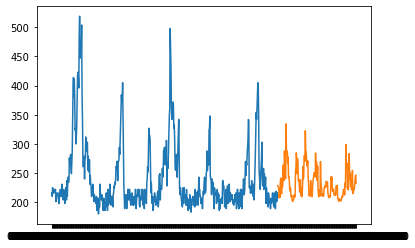

In [30]:
plt.plot(df['date'], df['electricity_consumption'], label='actual')
plt.plot(outputDf['date'], outputDf['electricity_consumption'], label='forecast')
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


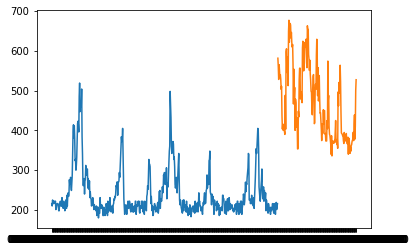

In [52]:
plt.plot(df['date'], df['electricity_consumption'], label='actual')
plt.plot(outputDf['date'], outputDf['electricity_consumption'], label='forecast')
plt.show()

In [ ]:
df2 = pd.Series(df['value'])